In [3]:
import pandas as pd
import numpy as np
import wurst as w

from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
from mpl_toolkits.axes_grid1 import make_axes_locatable

from config import * #some main key parameters needed.
from private_keys import * #import secret keys
from db_functions import * # this is a python file with self-created functions needed to run this notebook
from functions import *
from regionalization import *
from mapping import *
from plotting import *
import premise
premise.__version__

Adding REMIND and IMAGE topology using regionalization.py


(2, 2, 7)

### 1. Get and set bw project (here, the new databases and activities are already generated in ``0_set_up_database_gen_acts``:

In [4]:
# Import project
bw.projects.set_current(PROJECT_NAME) #Creating/accessing the project
DB_NAME_INIT, bw.databases,PROJECT_NAME

('ecoinvent-3.10-cutoff',
 Databases dictionary with 25 objects, including:
 	ecoinvent-3.10-biosphere
 	ecoinvent-3.10-cutoff
 	ecoinvent_310_reference
 	ecoinvent_image_SSP2-RCP26_2030_base
 	ecoinvent_image_SSP2-RCP26_2035_base
 	ecoinvent_image_SSP2-RCP26_2040_base
 	ecoinvent_image_SSP2-RCP26_2045_base
 	ecoinvent_image_SSP2-RCP26_2050_base
 	ecoinvent_remind_SSP2-PkBudg1150_2030_base
 	ecoinvent_remind_SSP2-PkBudg1150_2035_base
 Use `list(this object)` to get the complete list.,
 'steel_sector_cbam')

### The following are variables used to calculate different steps in this script:

In [5]:
"""
CURRENT (BASELINE) SCENARIO FLAGS
================================

These flags control the execution of the present-day / current steel
production scenario (no prospective changes).

As with future cases, the logic is split into:
- database construction
- LCA computation vs. loading
- contribution / CBAM-related analysis
- auxiliary market and CBAM-alpha calculations
"""

# ------------------------------------------------------------------
# Steel production database (current year)
# ------------------------------------------------------------------
create_new_steel_db = False
# True  → (Re)build the current steel Brightway database
# False → Reuse existing steel database (recommended unless inputs changed)

# ------------------------------------------------------------------
# Life Cycle Assessment (LCA)
# ------------------------------------------------------------------
calc_lca_impacts = False
# True  → Run LCA calculations and SAVE results to pickle
# False → LOAD results from existing pickle file

contri = False
# True  → Include contribution analysis (Scope 1/2/3, CBAM attribution)
# False → Skip contribution arrays (faster execution, smaller pickles)

# ------------------------------------------------------------------
# Market database (e.g. hydrogen, electricity, intermediates)
# ------------------------------------------------------------------
create_new_market_db = True
# True  → (Re)build market databases used by steel production
# False → Reuse existing market databases

# ------------------------------------------------------------------
# CBAM alpha calculation
# ------------------------------------------------------------------
calculate_alpha = False
# True  → Compute CBAM alpha (share of emissions covered by CBAM precursors)
# False → Load precomputed alpha or skip alpha calculation entirely

calc_lca_impacts_ind = False # to calculate CBAM coverage of all pathways

"""
Typical workflows
-----------------

1) First full run (fresh setup):
   create_new_steel_db = True
   create_new_market_db = True
   calc_lca_impacts = True
   contri = True
   calculate_alpha = True

2) Iteration / plotting / paper figures:
   create_new_steel_db = False
   create_new_market_db = False
   calc_lca_impacts = False
   contri = False
   calculate_alpha = False
"""

'\nTypical workflows\n-----------------\n\n1) First full run (fresh setup):\n   create_new_steel_db = True\n   create_new_market_db = True\n   calc_lca_impacts = True\n   contri = True\n   calculate_alpha = True\n\n2) Iteration / plotting / paper figures:\n   create_new_steel_db = False\n   create_new_market_db = False\n   calc_lca_impacts = False\n   contri = False\n   calculate_alpha = False\n'

In [6]:
### for prospective scenarios:

In [7]:
"""
CASE EXECUTION FLAGS
====================

Each prospective steel scenario is controlled by three boolean flags:

1) create_new_steel_db_*
   - True  → (Re)build the Brightway steel database for this scenario
   - False → Do NOT touch BW databases (assumes DB already exists)

2) calc_lca_impacts_*
   - True  → Run LCA calculations and SAVE results to pickle
   - False → LOAD results from existing pickle file

3) contri_*
   - True  → Include contribution analysis (Scope 1/2/3, CBAM splits)
   - False → Skip contribution arrays (faster, smaller pickles)

IMPORTANT:
- `create_new_steel_db_*` ONLY affects database construction
- `calc_lca_impacts_*` controls compute vs. load-from-pickle
- You can load pickles even if `create_new_steel_db_* = False`
- Typical workflow:
    * First run  : create_db=True,  calc_lca=True
    * Later runs : create_db=False, calc_lca=False
"""

# ------------------------------------------------------------------
# Electrowinning (EW, grid-mix electricity)
# ------------------------------------------------------------------
create_new_steel_db_future_ew = False   # build EW database?
calc_lca_impacts_future_ew   = False # compute LCA or load pickle?
contri_future_ew             = False   # include contribution analysis?

# ------------------------------------------------------------------
# Electrowinning with low-carbon electricity (EW + renewables)
# ------------------------------------------------------------------
create_new_steel_db_future_ew_lc = False
calc_lca_impacts_future_ew_lc   = False
contri_future_ew_lc             = False

# ------------------------------------------------------------------
# Low-carbon steel baseline (e.g. H2-DRI / LC case)
# ------------------------------------------------------------------
create_new_steel_db_future_lc = False  # rebuild DB
calc_lca_impacts_future_lc   = False # recompute LCA
contri_future_lc             = False  # include Scope + CBAM breakdowns

# ------------------------------------------------------------------
# Low-carbon steel baseline (e.g. H2-DRI)
# ------------------------------------------------------------------
create_new_steel_db_future = False
calc_lca_impacts_future   = False
contri_future             = False 

# ------------------------------------------------------------------
# BF-BOF + CCS future steel
# ------------------------------------------------------------------
create_new_steel_db_future_ccs = False
calc_lca_impacts_future_ccs   = False
contri_future_ccs             = False


### 2. Get the merged steel databases:

In [8]:
plants_mod_all = pd.read_excel('data\merged_steel_dbs.xlsx')
plants_mod_all['Continent'] = plants_mod_all['Country/Area'].apply(get_continent)
plants_mod_future = plants_mod_all.copy()
plants_mod_all

Unnamed: 0 Internal ID                    Project name  \
0              6     GST-007                      Hamburg H2   
1              9     GST-010  Whyalla Transformation Program   
2             11     GST-012                       tkH2Steel   
3             12     GST-013                Paradigm project   
4             14     GST-015             Oxelösund mini-mill   
...          ...         ...                             ...   
1041         997         NaN                             NaN   
1042         998         NaN                             NaN   
1043        1000         NaN                             NaN   
1044        1001         NaN                             NaN   
1045        1002         NaN                             NaN   

                                        Project website  \
0     https://web.archive.org/web/https://future.ham...   
1     https://web.archive.org/web/https://www.gfgall...   
2     https://web.archive.org/web/https://www.thysse...   
3     https://web.archive.org/web/https://tenova.com...   
4     https://web.archive.org/web/https://www.ssab.c...   
...                                                 ...   
1041                                                NaN   
1042                                                NaN   
1043                                                NaN   
1044                                                NaN   
1045                                                NaN   

                         Technology category Announcement transparency  \
0                             Phasing out BF                      High   
1                             Phasing out BF                      High   
2                             Phasing out BF                      High   
3                             Phasing out BF                    Medium   
4     Complementing conventional steelmaking                      High   
...                                      ...                       ...   
1041                                     NaN                       NaN   
1042                                     NaN                       NaN   
1043                                     NaN                       NaN   
1044                                     NaN                       NaN   
1045                                     NaN                       NaN   

     Project scale Year to be online         Technology to be used  \
0             Demo              2026                         H-DRI   
1       Full scale              2027               NG-DRI to H-DRI   
2       Full scale              2028               NG-DRI to H-DRI   
3       Full scale              2021               NG-DRI to H-DRI   
4       Full scale              2026  BF-BOF to EAF for green iron   
...            ...               ...                           ...   
1041           NaN               NaN                           NaN   
1042           NaN               NaN                           NaN   
1043           NaN               NaN                           NaN   
1044           NaN               NaN                           NaN   
1045           NaN               NaN                           NaN   

                                     Technology details  ...  \
0     First tested using grey hydrogen from waste gases  ...   
1     DRI+EAF Fed by Natural Gas in transitioning to...  ...   
2                                           MIDREX Flex  ...   
3     Gas mixture composed by 30% of coke oven gas f...  ...   
4                               EAF using HBI and scrap  ...   
...                                                 ...  ...   
1041                                                NaN  ...   
1042                                                NaN  ...   
1043                                                NaN  ...   
1044                                                NaN  ...   
1045                                                NaN  ...   

     EAF steel production (DR

In [9]:
# Define all relevant statuses
valid_statuses = [
    'Operating', 'operating',
    'operating pre-retirement',
    'Finalized (research & testing)'
]

# Get "operating" plants IDs based on those statuses
operating_plants = plants_mod_all.loc[
    plants_mod_all['Capacity operating status'].isin(valid_statuses),
    'Plant ID'
].unique()

# Now filter plants_mod_all using the broader statuses
plants_mod_all = plants_mod_all[
    plants_mod_all['Capacity operating status'].isin(valid_statuses) |
    (
        (plants_mod_all['Capacity operating status'] == 'operating pre-retirement') &
        (~plants_mod_all['Plant ID'].isin(operating_plants))
    )
]

# Optional: review resulting statuses
plants_mod_all['Capacity operating status'].value_counts()

Capacity operating status
operating                         783
operating pre-retirement           47
Operating                           3
Finalized (research & testing)      3
Name: count, dtype: int64

In [10]:
plants_mod_all = plants_mod_all[~plants_mod_all['steel_or_iron_production'].str.contains('iron', case=False, na=False)]
plants_mod_all['Capacity operating status'].value_counts()

Capacity operating status
operating                   751
operating pre-retirement     47
Name: count, dtype: int64

___
### 3. Now, we will have to write an equation that properly accounts what are the emission scopes and whether included in current CBAM:

___
### Determine alpha, share of embodied emissions

In [11]:
iron_alpha_seeds = {
    k: v for k, v in CBAM_RELEVANT_PRECURSORS_IRON.items()
    # optionally filter if you only want certain iron products:
    if k in {"pig iron", "direct reduced iron"}
}

if calculate_alpha:
    alpha, data = calculate_cbam_alpha(
        db_name=NAME_REF_DB,
        method=MY_METHODS[0],
        cbam_act_to_get_alpha_steel = {k: v for k, v in CBAM_RELEVANT_PRECURSORS_STEEL.items() if k == "steel"}, #steel
        cbam_act_to_get_alpha_iron = {k: v for k, v in CBAM_RELEVANT_PRECURSORS_STEEL.items() if k in {"pig iron", "direct reduced iron"}}, #pig iron or dri
        cbam_precursors_excl_steel=CBAM_RELEVANT_PRECURSORS_STEEL,
        cbam_precursors_excl_iron=CBAM_RELEVANT_PRECURSORS_IRON,
        threshold=90,
        cbam_threshold=0.275 # recursively defined
    )
    print("Alpha:", alpha)
    %store alpha

    alpha_fut, data_future = calculate_cbam_alpha(
        db_name='ecoinvent_image_SSP2-RCP26_2040_base',
        method=MY_METHODS[0],
        cbam_act_to_get_alpha_steel = {k: v for k, v in CBAM_RELEVANT_PRECURSORS_STEEL.items() if k == "steel"}, #steel
        cbam_act_to_get_alpha_iron = {k: v for k, v in CBAM_RELEVANT_PRECURSORS_STEEL.items() if k in {"pig iron", "direct reduced iron"}}, #pig iron or dri
        cbam_precursors_excl_steel=CBAM_RELEVANT_PRECURSORS_STEEL,
        cbam_precursors_excl_iron=CBAM_RELEVANT_PRECURSORS_IRON,
        threshold=90,
        cbam_threshold=0.275 # recursively defined
    )
    print("Alpha future:", alpha_fut)
    %store alpha_fut
else:
    %store -r alpha
    %store -r alpha_fut
alpha,alpha_fut

(0.803934892580146, 0.8809873986105885)

In [12]:
all_ei_databases = [db_2 for db_2 in bw.databases if "ecoinvent_image" in str(db_2) or NAME_REF_DB in str(db_2)]
for year in range(2025, 2051):
    matched_database = match_year_to_database(year)
    print(f"Matched database for year {year}: {matched_database}")

Matched database for year 2025: ecoinvent_310_reference
Matched database for year 2026: ecoinvent_310_reference
Matched database for year 2027: ecoinvent_310_reference
Matched database for year 2028: ecoinvent_image_SSP2-RCP26_2030_base
Matched database for year 2029: ecoinvent_image_SSP2-RCP26_2030_base
Matched database for year 2030: ecoinvent_image_SSP2-RCP26_2030_base
Matched database for year 2031: ecoinvent_image_SSP2-RCP26_2030_base
Matched database for year 2032: ecoinvent_image_SSP2-RCP26_2030_base
Matched database for year 2033: ecoinvent_image_SSP2-RCP26_2035_base
Matched database for year 2034: ecoinvent_image_SSP2-RCP26_2035_base
Matched database for year 2035: ecoinvent_image_SSP2-RCP26_2035_base
Matched database for year 2036: ecoinvent_image_SSP2-RCP26_2035_base
Matched database for year 2037: ecoinvent_image_SSP2-RCP26_2035_base
Matched database for year 2038: ecoinvent_image_SSP2-RCP26_2040_base
Matched database for year 2039: ecoinvent_image_SSP2-RCP26_2040_base
Matc

___
### 6. Now, create LCI for each facility and regionalize and account for potential low-carbon energy sources mentioned.

In [13]:
if create_new_steel_db:
    ref_db_w = w.extract_brightway2_databases(NAME_REF_DB, add_properties=False, add_identifiers=False)
    ref_db_w_2030 = w.extract_brightway2_databases('ecoinvent_image_SSP2-RCP26_2030_base', add_properties=False, add_identifiers=False)
    ref_db_w_2035 = w.extract_brightway2_databases('ecoinvent_image_SSP2-RCP26_2035_base', add_properties=False, add_identifiers=False)
    ref_db_w_2040 = w.extract_brightway2_databases('ecoinvent_image_SSP2-RCP26_2040_base', add_properties=False, add_identifiers=False)
    ref_db_w_2045 = w.extract_brightway2_databases('ecoinvent_image_SSP2-RCP26_2045_base', add_properties=False, add_identifiers=False)
    ref_db_w_2050 = w.extract_brightway2_databases('ecoinvent_image_SSP2-RCP26_2050_base', add_properties=False, add_identifiers=False)
    bio_db_w = w.extract_brightway2_databases(BIOSPHERE_DB, add_properties=False, add_identifiers=False)

    database_sel = {NAME_REF_DB:ref_db_w,
                    BIOSPHERE_DB:bio_db_w,
                    'ecoinvent_image_SSP2-RCP26_2030_base':ref_db_w_2030,
                    'ecoinvent_image_SSP2-RCP26_2035_base':ref_db_w_2035,
                    'ecoinvent_image_SSP2-RCP26_2040_base':ref_db_w_2040,
                    'ecoinvent_image_SSP2-RCP26_2045_base':ref_db_w_2045,
                    'ecoinvent_image_SSP2-RCP26_2050_base':ref_db_w_2050
                   }

In [14]:
new_steel_activities = []
db_name = "steel_db"
start_idx = 0

all_names = []

if create_new_steel_db:
    from regionalization import * 
    
    if db_name in list(bw.databases):
        del bw.databases[db_name]

    counter = 1
    for counter, (index, row) in enumerate(plants_mod_all.iterrows(), start=1):
        if index < start_idx:
            continue  # Skip until we reach the desired index
            
        if row['steel_or_iron_production'] == 'both' or row['steel_or_iron_production'] == 'steel':
            sum_end_uses = row.filter(regex='steel production')
        elif row['steel_or_iron_production'] == 'iron':
            sum_end_uses = row.filter(like=' production').filter(regex='^(?!.*(steel|Company)).*$')
        else:
            raise ValueError("ERROR")
            
        sum_end_uses = sum_end_uses.dropna()[sum_end_uses > 0]
        row.fillna(np.nan,inplace=True)
        
        print(f"{counter}/{len(plants_mod_all)}", end="\r", flush=True)
        counter += 1

        for k, end_use in enumerate(list(sum_end_uses.index)):
            plant_name = row['Plant name (English)_x']
        
            if pd.isna(plant_name):
                year_field = row['Year to be online']
            else:
                year_field = row['Start date']

            # Determine the year of the steel plant, if not is unknown and we use the ref db.
            if pd.notna(year_field) and (isinstance(year_field, (int, float)) or (isinstance(year_field, str) and year_field.isdigit())):
                year = int(year_field)
                matched_database = match_year_to_database(year)
                db_sel = database_sel[matched_database]
            else:
                year = "Unknown"
                db_sel = database_sel[NAME_REF_DB]

            # get the best matched activity
            if pd.isna(plant_name):
                # this is the case with the low-carbon steel db, we have to make some changes
                plant_name = f"{row['Project name']}_{row['Internal ID']}_{year}"
                search_tech = f"{row['steel_or_iron_production']}-{row['steel_decarb_classification']}"
                match_activity = dict_acts[row["steel_classification"]].get(search_tech)
            else:
                match_activity = dict_acts[row["steel_classification"]].get(end_use)

            iso2 = country_to_iso2(row['Country/Area'])

            # Make new activity name and dictionary data + regionalize exchanges of this activity, which are processed in the next step
            new_act, activity_to_adapt, new_code = create_regionalized_activity(
                                db_sel,
                                match_activity,
                                iso2,
                                row,
                                end_use,
                                db_name,
                                plant_name,
                                year
                            )
            
            if new_act['name'] in all_names:
                print(f"WARNING: Activity already exists, skipping plant name with ID: '{new_act['name']}', '{row['Plant ID']}'")
                continue
                
            all_names.append(new_act['name'])

            # process exchanges, potentially further regioanlize by changing power, heat, and/or hydrogen sources used.
            new_act['exchanges'] = process_exchanges(activity_to_adapt, row, matched_database, db_name, iso2, db_sel, new_code, bio_db_w, 
                                                     plant_type = row['steel_or_iron_production'])
            
            new_steel_activities.append(new_act)      

In [15]:
#%store new_steel_activities
#%store -r new_steel_activities

#%store new_steel_activities
%store -r new_steel_activities

In [16]:
if create_new_steel_db:
    process_import(db_name, new_steel_activities, iam='image')

    annotate_exchanges_with_cbam(
        db_name=db_name,
        define_scope_cbam_func=define_scope_cbam)

___
### 7. Calculate LCA results:

In [17]:
results_df = calc_lca_impacts_all_plants(
    steel_method="",
    db_name_base="steel_db",          # <- your base, without "_ccs"
    methods=MY_METHODS,
    calc_lca_impacts=calc_lca_impacts,
    contri=contri,
    start_idx=0,
    european_countries=european_countries,
    dict_types=dict_types,
    sum_exchanges_wo_transport=sum_exchanges_wo_transport,
)
results_df = results_df[results_df.year < 2026]  # for the current scenario, exclude facilities planned for the future
results_df

name  year      unit  \
380  steel production, converter, unalloyed, only p...  1958  kilogram   
702  steel production, converter, unalloyed, only p...  1958  kilogram   
401  steel production, converter, low-alloyed, only...  2002  kilogram   
867  steel production, converter, unalloyed, only p...  2002  kilogram   
858  steel production, converter, low-alloyed, only...  1984  kilogram   
..                                                 ...   ...       ...   
829  steel production, electric, low-alloyed for fa...  1930  kilogram   
781  steel production, electric, low-alloyed for fa...  1771  kilogram   
79   steel production, electric, low-alloyed for fa...  1902  kilogram   
229  steel production, electric, low-alloyed for fa...  1884  kilogram   
553  steel production, electric, low-alloyed for fa...  1900  kilogram   

    country location   reference product  production volume  database  \
380      CN       CN    steel, unalloyed             71.819  steel_db   
702      CN       CN    steel, unalloyed             67.755  steel_db   
401      CN       CN  steel, low-alloyed             35.506  steel_db   
867      CN       CN    steel, unalloyed             27.000  steel_db   
858      CN       CN  steel, low-alloyed             15.952  steel_db   
..      ...      ...                 ...                ...       ...   
829      SE       SE  steel, low-alloyed              0.350  steel_db   
781      RO       RO  steel, low-alloyed              0.211  steel_db   
79       ES       ES  steel, low-alloyed              0.200  steel_db   
229      RO       RO  steel, low-alloyed              0.100  steel_db   
553      RU       RU  steel, low-alloyed              0.077  steel_db   

                                          initial name  \
380  steel production, converter, unalloyed, only p...   
702  steel production, converter, unalloyed, only p...   
401  steel production, converter, low-alloyed, only...   
867  steel production, converter, unalloyed, only p...   
858  steel production, converter, low-alloyed, only...   
..                                                 ...   
829            steel production, electric, low-alloyed   
781            steel production, electric, low-alloyed   
79             steel production, electric, low-alloyed   
229            steel production, electric, low-alloyed   
553            steel production, electric, low-alloyed   

                                               comment  ...   longitude  \
380  Geography:  Data are taken from basic oxygen f...  ...  112.897377   
702  Geography:  Data are taken from basic oxygen f...  ...  111.967343   
401  Geography:  Data are taken from basic oxygen f...  ...  115.184798   
867  Geography:  Data are taken from basic oxygen f...  ...  120.638992   
858  Geography:  Data are taken from basic oxygen f...  ...  113.981172   
..                                                 ...  ...         ...   
829  Geography:  Data are taken from electric arc f...  ...   16.172808   
781  Geography:  Data are taken from electric arc f...  ...   21.902410   
79   Geography:  Data are taken from electric arc f...  ...   -2.998964   
229  Geography:  Data are taken from electric arc f...  ...   22.916270   
553  Geography:  Data are taken from electric arc f...  ...   59.650247   

     power_source lca_impact_climate change  lca_impact_co2 emissions  \
380          grid                  2.387438                  2.073200   
702          grid                  2.387438                  2.073200   
401          grid                  2.768908                  2.457153   
867            pv                  2.341550                  2.034721   
858          grid                  2.768908                  2.457153   
..            ...                       ...                       ...   
829          grid                  0.371723                  0.367523   
781          grid                  0.557037                  0.537214   
79      renewable            

In [18]:
(results_df['lca_impact_co2 emissions'] * results_df['production volume']).sum()

3566.753342428073

In [19]:
# Convert to DataFrame
data_x = results_df.iloc[-200]['lca_impact_contri_climate change']
df_x = pd.DataFrame(data_x, columns=['Exchange', 'Climate impact', 'Scope', 'CBAM', 'Amount'])
#df_x['spec_impact [kgCO2-eq./FU exchange]'] = df_x['Climate impact']/df_x['Amount']
df_x

Exchange  Climate impact  Scope   CBAM  \
0                         Antimony ion    0.000000e+00      1   True   
1                                Argon    0.000000e+00      1   True   
2                          Arsenic ion    0.000000e+00      1   True   
3                              Benzene    0.000000e+00      1   True   
4                           Cadmium II    0.000000e+00      1   True   
..                                 ...             ...    ...    ...   
124   market for spent solvent mixture    2.710520e-08      3  False   
125             market for sponge iron    3.606061e-01      3   True   
126  market for sulfur dioxide, liquid    4.014646e-06      3  False   
127           market for sulfuric acid    1.207712e-06      3  False   
128     market for wastewater, average    1.215329e-02      3  False   

           Amount  
0    4.203014e-10  
1    1.556062e-05  
2    4.754228e-10  
3    8.486368e-07  
4    1.911182e-08  
..            ...  
124 -2.222655e-08  
125  1.749856e-01  
126  8.612733e-06  
127  6.757750e-06  
128 -2.822305e-02  

[129 rows x 5 columns]

In [20]:
results_df.iloc[-200]

name                                      steel production, electric, low-alloyed for fa...
year                                                                                   2007
unit                                                                               kilogram
country                                                                                  MY
location                                                                                 MY
reference product                                                        steel, low-alloyed
production volume                                                                      0.63
database                                                                           steel_db
initial name                                        steel production, electric, low-alloyed
comment                                   This activity represents the production of sec...
latitude                                                                        

In [21]:
total_emissions = results_df['Plant_GHG_emissions_Mt_wo_transport'].sum()
total_production = results_df['production volume'].sum()
emissions_intensity = total_emissions / total_production

print(f"Total GHG emissions (without transport): {total_emissions:.2f} Mt")
print(f"Total production volume: {total_production:.2f}")
print(f"Emissions intensity: {emissions_intensity:.2f} kgCO2-eq./kg steel")

Total GHG emissions (without transport): 4009.17 Mt
Total production volume: 1918.22
Emissions intensity: 2.09 kgCO2-eq./kg steel


In [22]:
# Determine scope of emissions as well as cbam:
results_df[['Scope 1', 'Scope 2', 'Scope 3']] = results_df[
    'lca_impact_contri_climate change'].apply(sum_scope_contributions).apply(pd.Series)

results_df[['cbam_true', 'cbam_false']] = results_df[
    'lca_impact_contri_climate change'].apply(sum_cbam_contributions, alpha=alpha).apply(pd.Series)

results_df['cbam_true_total_cc'] = results_df['cbam_true'] * results_df['production volume']
results_df['cbam_false_total_cc'] = results_df['cbam_false'] * results_df['production volume']
results_df['share_cbam_covered'] = results_df['cbam_true_total_cc']/(results_df['cbam_true_total_cc'] + results_df['cbam_false_total_cc'])

results_df['latitude'] = pd.to_numeric(results_df['latitude'], errors='coerce')
results_df['longitude'] = pd.to_numeric(results_df['longitude'], errors='coerce')
results_df['share_cbam_covered'].describe()

count    842.000000
mean       0.617415
std        0.093892
min        0.216592
25%        0.619397
50%        0.638511
75%        0.668062
max        0.788896
Name: share_cbam_covered, dtype: float64

In [23]:
results_df[['cbam_true_efactor', 'cbam_false_efactor']] = results_df[
    'lca_impact_contri_climate change'].apply(sum_cbam_contributions_emission_factor, alpha=alpha).apply(pd.Series)

results_df['cbam_true_total_cc_efactor'] = results_df['cbam_true_efactor'] * results_df['production volume']
results_df['cbam_false_total_cc_efactor'] = results_df['cbam_false_efactor'] * results_df['production volume']
results_df['share_cbam_covered_efactor'] = results_df['cbam_true_total_cc_efactor']/(results_df['cbam_true_total_cc_efactor'] + results_df['cbam_false_total_cc_efactor'])
results_df['share_cbam_covered_efactor'].describe()

count    842.000000
mean       0.614122
std        0.092691
min        0.216592
25%        0.619397
50%        0.633093
75%        0.662374
max        0.788896
Name: share_cbam_covered_efactor, dtype: float64

In [24]:
# What if we exclude scope 2 from CBAM coverage?
results_df[['cbam_true_exclude_scope_2', 'cbam_false_exclude_scope_2']] = results_df[
    'lca_impact_contri_climate change'].apply(sum_cbam_contributions, alpha=alpha, exclude_scope_2=True).apply(pd.Series)

results_df['cbam_true_total_cc_exclude_scope_2'] = results_df['cbam_true_exclude_scope_2'] * results_df['production volume']
results_df['cbam_false_total_cc_exclude_scope_2'] = results_df['cbam_false_exclude_scope_2'] * results_df['production volume']
results_df['share_cbam_covered_exclude_scope_2'] = results_df['cbam_true_total_cc_exclude_scope_2']/(results_df['cbam_true_total_cc_exclude_scope_2'] + results_df['cbam_false_total_cc_exclude_scope_2'])
results_df['share_cbam_covered_exclude_scope_2'].describe()

count    842.000000
mean       0.467250
std        0.174732
min        0.080484
25%        0.374239
50%        0.472054
75%        0.619519
max        0.767109
Name: share_cbam_covered_exclude_scope_2, dtype: float64

In [25]:
nr_loc = 500
print(results_df.iloc[nr_loc][['cbam_true', 'cbam_false']],results_df.iloc[nr_loc][['cbam_true_exclude_scope_2', 'cbam_false_exclude_scope_2']])
data_x = results_df.iloc[nr_loc]['lca_impact_contri_climate change']
df_x = pd.DataFrame(data_x, columns=['Exchange', 'Climate impact', 'Scope', 'CBAM', 'Amount'])
df_x

cbam_true     0.591674
cbam_false    0.526493
Name: 377, dtype: object cbam_true_exclude_scope_2     0.549602
cbam_false_exclude_scope_2    0.568565
Name: 377, dtype: object


Exchange  Climate impact  Scope   CBAM  \
0                         Antimony ion    0.000000e+00      1   True   
1                                Argon    0.000000e+00      1   True   
2                          Arsenic ion    0.000000e+00      1   True   
3                              Benzene    0.000000e+00      1   True   
4                           Cadmium II    0.000000e+00      1   True   
..                                 ...             ...    ...    ...   
124   market for spent solvent mixture    2.710520e-08      3  False   
125             market for sponge iron    3.606061e-01      3   True   
126  market for sulfur dioxide, liquid    4.014646e-06      3  False   
127           market for sulfuric acid    1.207712e-06      3  False   
128     market for wastewater, average    1.215329e-02      3  False   

           Amount  
0    4.203014e-10  
1    1.556062e-05  
2    4.754228e-10  
3    8.486368e-07  
4    1.911182e-08  
..            ...  
124 -2.222655e-08  
125  1.749856e-01  
126  8.612733e-06  
127  6.757750e-06  
128 -2.822305e-02  

[129 rows x 5 columns]

## Some checks regarding act relevant precursors and if they are not matched:

In [26]:
from mapping import CBAM_RELEVANT_PRECURSORS_STEEL
cbam_issues_df = check_cbam_coverage(results_df, CBAM_RELEVANT_PRECURSORS_STEEL)
cbam_issues_df

Empty DataFrame
Columns: []
Index: []

In [27]:
df_countries = pd.read_excel(r'data\df_countries.xlsx', index_col = "location").reset_index()
#results_df = pd.merge(results_df, df_countries, on='location') # add lat lon info
# Add a new column to the DataFrame to classify countries as European or Non-European
results_df['region'] = results_df['location'].apply(lambda x: 'European' if x in european_countries else 'Non-European')
results_df["Plant_GHG_emissions_Mt"] = results_df['production volume']*results_df['lca_impact_climate change']

___
### 7. Get the steel from other continents and create national and continental steel markets:

In [28]:
#slide 36 of https://www.eurofer.eu/assets/publications/brochures-booklets-and-factsheets/european-steel-in-figures-2025/European-Steel-in-Figures-2025_23062025.pdf
steel_import_2024 = {
    "KR": 3304,  # South Korea
    "IN": 3296,  # India
    "TW": 2266,  # Taiwan
    "TR": 3909,  # Turkey
    "CN": 1969,  # China
    "VN": 2617,  # Vietnam
    "JP": 1403,  # Japan
    "EG": 1212,  # Egypt
    "UA": 1677,  # Ukraine
    "ID": 726,   # Indonesia
    "Others": 4988  # No ISO2 code for "Others"
}

exclude_countries = list(steel_import_2024.keys()) + eu27_countries
results_df['commodity_type'] = results_df['initial name'].map(dict_types)
exclude_countries.remove('Others')

In [29]:
steel_import_2024 

{'KR': 3304,
 'IN': 3296,
 'TW': 2266,
 'TR': 3909,
 'CN': 1969,
 'VN': 2617,
 'JP': 1403,
 'EG': 1212,
 'UA': 1677,
 'ID': 726,
 'Others': 4988}

In [30]:
results_df['commodity_type'].unique()

array(['primary steel (BF-BOF)', 'secondary steel (EAF)',
       'primary steel (DRI-EAF, NG)'], dtype=object)

# Now, generate global and country-specific market activities for steel production:

In [31]:
if create_new_market_db:
    db_sel_markets = w.extract_brightway2_databases(db_name, add_properties=False, add_identifiers=False)
    #db_sel = w.extract_brightway2_databases(db_name, add_properties=False, add_identifiers=False)

Getting activity data


100%|██████████| 870/870 [00:00<00:00, 433738.79it/s]


Adding exchange data to activities


100%|██████████| 73713/73713 [00:02<00:00, 27344.94it/s]


Filling out exchange data


100%|██████████| 870/870 [00:00<00:00, 2491.64it/s]


In [32]:
# Fill missing years with default (2024 assumed to be the "current" year)
results_df['year'] = results_df['year'].fillna(2025)

new_market_activities = []
db_name_markets = "steel_market_db"
name_comm = 'steel' # can be via primary or secondary production, or just a market combining them. 

# We don't make a distinction here between low-alloyed and unalloyed steel
if create_new_market_db:
    # create country-specific markets
    new_market_activities = create_steel_market_activities(results_df, db_sel_markets, db_name, db_name_markets )

C:\Users\terlouw_t\AppData\Local\Temp\ipykernel_23992\4028244827.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  results_df['year'] = results_df['year'].fillna(2025)


In [33]:
if create_new_market_db:
    market_definitions = [
        {
            "market_name": "Others",
            "market_location_label": "Others",
            "location_filter_fn": lambda df: ~df.location.isin(exclude_countries),
        },
        {
            "market_name": "Non-EU-27",
            "market_location_label": "Non-EU-27",
            "location_filter_fn": lambda df: ~df.location.isin(eu27_countries),
        },
        {
            "market_name": "EU-27",
            "market_location_label": "EU-27",
            "location_filter_fn": lambda df: df.location.isin(eu27_countries),
        },
        {
            "market_name": "GLO",
            "market_location_label": "GLO",
            "location_filter_fn": lambda df: df.location.notnull(),
        },
    ]

    # Now, make those larger markers and append to the country markers of before
    for market in market_definitions:
        new_market = create_market_activity(
            name_comm=name_comm,
            results_df=results_df,
            db_sel=db_sel_markets,
            db_name=db_name,
            db_name_markets=db_name_markets,
            market_name=market["market_name"],
            market_location_label=market["market_location_label"],
            location_filter_fn=market["location_filter_fn"],
            w=w
        )
        new_market_activities.append(new_market)
#new_market_activities[76]

In [34]:
if create_new_market_db:
    if db_name_markets in list(bw.databases):
        del bw.databases[db_name_markets]    
    create_database(db_name_markets)
    process_import(db_name_markets, new_market_activities)

Database 'steel_market_db' has been created and registered.
Applying strategy: add_database_name
Applying strategy: csv_restore_tuples
Applying strategy: drop_empty_categories
Applying strategy: drop_empty_categories_2
Applying strategy: strip_nonsense
Applied 5 strategies in 0.02 seconds
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields


Writing activities to SQLite3 database:


77 datasets
2864 exchanges
0 unlinked exchanges
  
Wrote matching file to:
C:\Users\terlouw_t\AppData\Local\pylca\Brightway3\steel_sector_cbam.fd232721bdc6f1e9f65278e28448e7cf\output\db-matching-steel_market_db-unlinked.xlsx


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 02/22/2026 09:21:28
  Finished: 02/22/2026 09:21:28
  Total time elapsed: 00:00:00
  CPU %: 0.00
  Memory %: 2.52
Created database: steel_market_db


sum_vol=0

for act in bw.Database('steel_db'):
    year = int(m.group(1)) if (m := re.search(r'\[(\d{4})\]', act['name'])) else None
    if year is None or year < 2024:
        print(year)
        sum_vol += float(act['production volume'])
sum_vol

# Make a global market with excluding countries given in the dictionary:

In [35]:
for act in bd.Database("steel_market_db"):
    if act['location'] == "Non-EU-27":
        print(act.as_dict())

{'location': 'Non-EU-27', 'database': 'steel_market_db', 'code': '86d8f9ce86b94cc99a60efeea4a9d512', 'name': 'market for steel', 'reference product': 'steel', 'amount': 1, 'unit': 'kilogram', 'production volume': 1785.6850000000002}


In [36]:
for act in bd.Database("steel_market_db"):
    if act['location'] == "EU-27":
        print(act.as_dict())

{'location': 'EU-27', 'database': 'steel_market_db', 'code': '3562be2dae0e4b66bd12e9ca48dd6198', 'name': 'market for steel', 'reference product': 'steel', 'amount': 1, 'unit': 'kilogram', 'production volume': 132.53299999999993}


In [37]:
for act in bd.Database("steel_market_db"):
    if act['location'] == "GLO":
        print(act.as_dict())

{'location': 'GLO', 'database': 'steel_market_db', 'code': '6f08def492454e3b891193977b875b72', 'name': 'market for steel', 'reference product': 'steel', 'amount': 1, 'unit': 'kilogram', 'production volume': 1918.2179999999994}



CBAM emissions (EU import):
  - Total production volume exported to EU: 27.37 Mt
  - Total life-cycle emissions: 52.74 tonnes CO2e
  - Emissions excluded from CBAM: 17.86 tonnes CO2e
  - Emissions included in CBAM (covered): 34.88 tonnes CO2e
  - Share of emissions covered under CBAM: 66.14%


c:\Users\terlouw_t\.conda\envs\bw_reg_prem\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
c:\Users\terlouw_t\.conda\envs\bw_reg_prem\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


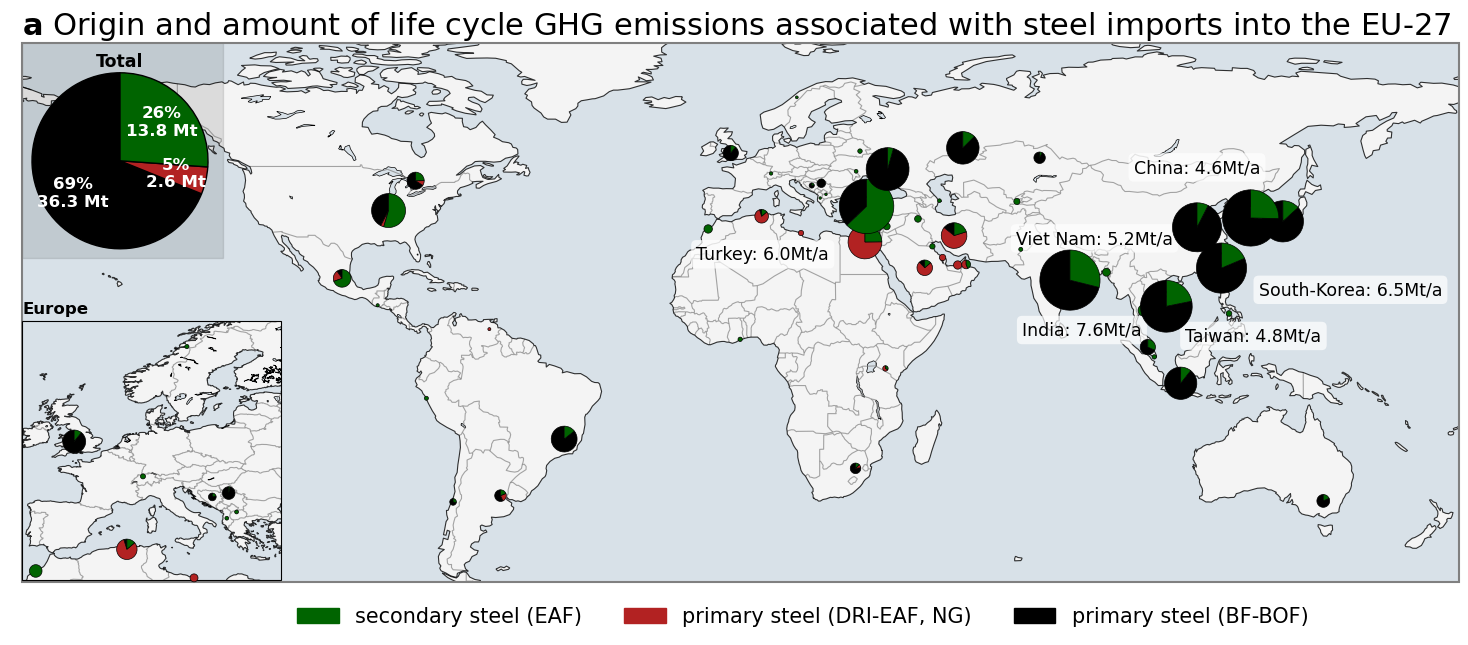

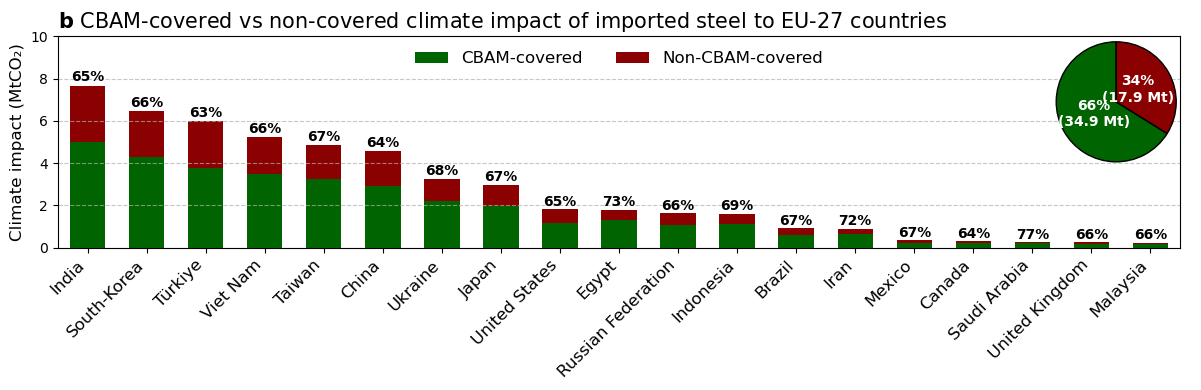


CBAM emissions excluding Scope 2 (EU import):
  - Total production volume exported to EU: 27.37 Mt
  - Total life-cycle emissions: 52.74 tonnes CO2e
  - Emissions excluded from CBAM: 21.93 tonnes CO2e
  - Emissions included in CBAM (covered): 30.81 tonnes CO2e
  - Share of emissions covered under CBAM: 58.42%


c:\Users\terlouw_t\.conda\envs\bw_reg_prem\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
c:\Users\terlouw_t\.conda\envs\bw_reg_prem\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


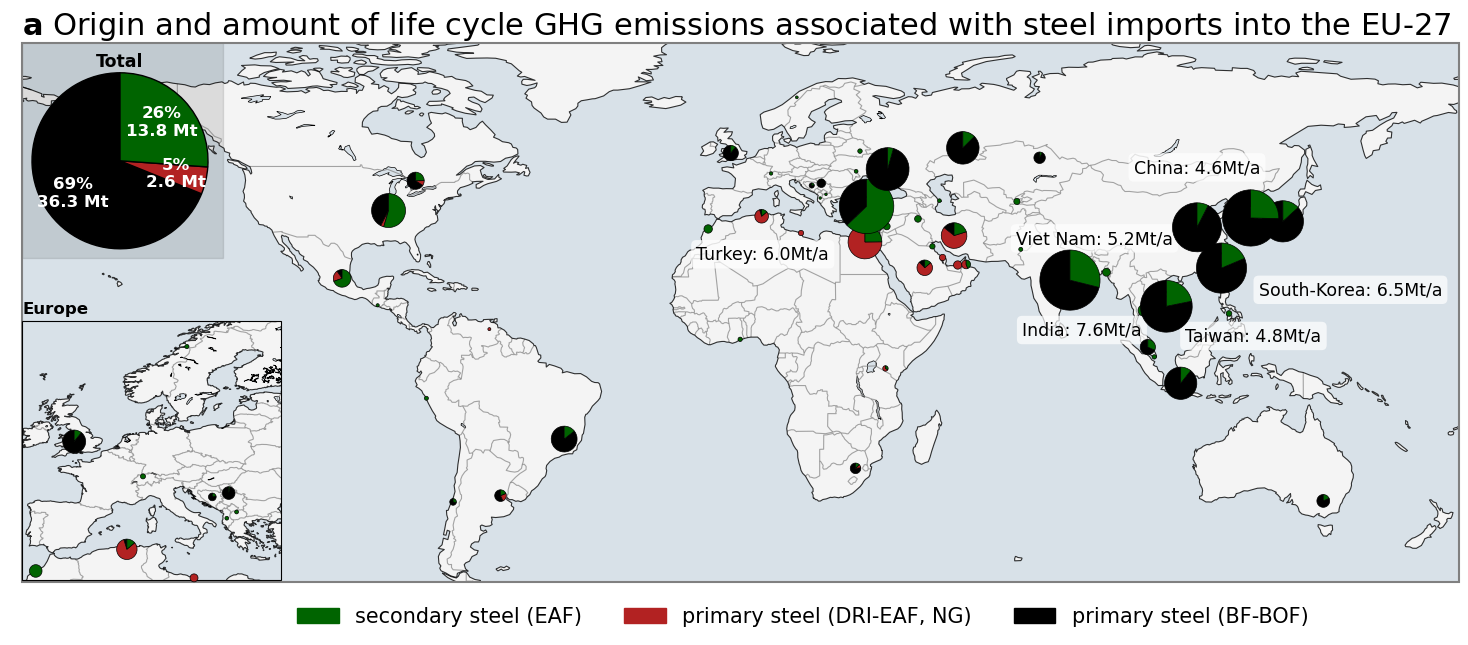

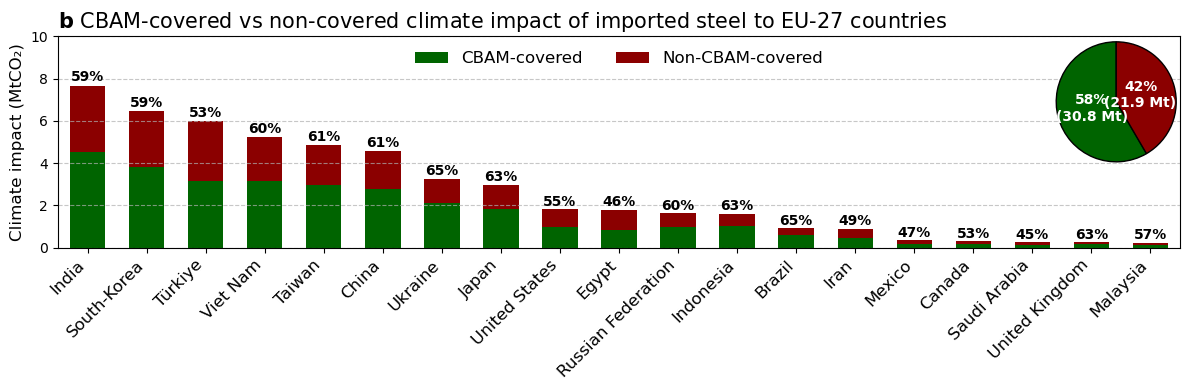

In [67]:
import_df = pd.DataFrame({})

# Define scenarios with their corresponding share column names
scenarios = [
    ('share_cbam_covered', 'CBAM emissions (EU import):'),
    ('share_cbam_covered_exclude_scope_2', 'CBAM emissions excluding Scope 2 (EU import):')
]

for share_column, report_title in scenarios:
    temp_import_df = pd.DataFrame({})
    
    for import_c in list(steel_import_2024.keys()):
        act_market = [act for act in bd.Database("steel_market_db") if act['location'] == import_c][0]
        
        for exc in act_market.exchanges():
            if exc['type'] != 'production':
                row_sel = results_df[results_df['name'] == exc['name']].copy()
                row_sel['production_volume_to_EU'] = exc['amount'] * steel_import_2024[import_c] / 1e3
                row_sel['Mt_emissions_shift_from_EU'] = row_sel['production_volume_to_EU'] * row_sel['lca_impact_climate change']
                row_sel['cbam_included_emissions_export_EU'] = row_sel['production_volume_to_EU'] * row_sel['lca_impact_climate change'] * row_sel[share_column]
                row_sel['cbam_excluded_emissions_export_EU'] = row_sel['production_volume_to_EU'] * row_sel['lca_impact_climate change'] * (1 - row_sel[share_column])
                
                temp_import_df = pd.concat([temp_import_df, row_sel], ignore_index=True)
    
    # Calculate totals
    excluded_emissions = temp_import_df['cbam_excluded_emissions_export_EU'].sum()
    included_emissions = temp_import_df['cbam_included_emissions_export_EU'].sum()
    total_emissions = excluded_emissions + included_emissions
    production_volume = temp_import_df['production_volume_to_EU'].sum()
    
    cbam_coverage_share = included_emissions / total_emissions if total_emissions > 0 else 0
    
    # Print report
    print(f"\n{report_title}")
    print(f"  - Total production volume exported to EU: {production_volume:,.2f} Mt")
    print(f"  - Total life-cycle emissions: {total_emissions:,.2f} tonnes CO2e")
    print(f"  - Emissions excluded from CBAM: {excluded_emissions:,.2f} tonnes CO2e")
    print(f"  - Emissions included in CBAM (covered): {included_emissions:,.2f} tonnes CO2e")
    print(f"  - Share of emissions covered under CBAM: {cbam_coverage_share:.2%}")

    pot_cols = ['Mt_emissions_shift_from_EU']#,'cbam_included_emissions_export_EU', 'cbam_excluded_emissions_export_EU', ]

    plot_steel_map(temp_import_df, pot_cols, subplot=False, titles = 
                        [r'$\mathbf{a}$ Origin and amount of life cycle GHG emissions associated with steel imports into the EU-27',
                        #r'$\mathbf{b}$ Shifted GHG emissions from steel production included in CBAM',
                        # r'$\mathbf{c}$ Shifted GHG emissions from steel production excluded in CBAM'
                        ],
                division_bubble=3, amount_show_bubble=[4, 2, 1], non_rounding=1, 
                export_figure=f'map_cbam_coverage_{share_column}',
                dict_pos = {'Brazil': (-7.5, 0),
                            'Viet Nam': (+17, +18),
                            'Ukraine': (+4, +22),
                            'China': (+15, 0),
                            'Germany': (+6, 0),
                            'India': (-12.5, -3),
                            'Iran, Islamic Republic of': (10, -19),
                            'Iran': (10, -19),
                            'Taiwan, Province of China'
                            : (-12, -19),
                            'Japan': (-9, -20),
                            #'Korea, Republic of': (+5, +45),
                            'South-Korea': (-18, -25),
                            'Russian Federation': (+10, -40),
                            'Türkiye': (-12, +26),
                            'United States': (-8, 0),
                            'Taiwan': (-17, -8),
                            'Egypt': (-14, 0)
                            }, 
                pos_legend_false_subplot = (70, -5.5),
                custom_autopct=custom_autopct_2
                        )
    
    plot_cbam_covered_stacked(temp_import_df, export_figure=f'cbam_coverage_{share_column}', max_y=10)



___
### 8. We have all the results now for plotting
### Plot steel production

#https://static1.squarespace.com/static/5877e86f9de4bb8bce72105c/t/624ebc5e1f5e2f3078c53a07/1649327229553/Steel+climate+impact-benchmarking+report+7April2022.pdf
#https://climateactiontracker.org/documents/1222/CAT_2024-07-09_Briefing_ParisBenchmarks_SteelSector.pdf

c:\Users\terlouw_t\.conda\envs\bw_reg_prem\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
c:\Users\terlouw_t\.conda\envs\bw_reg_prem\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


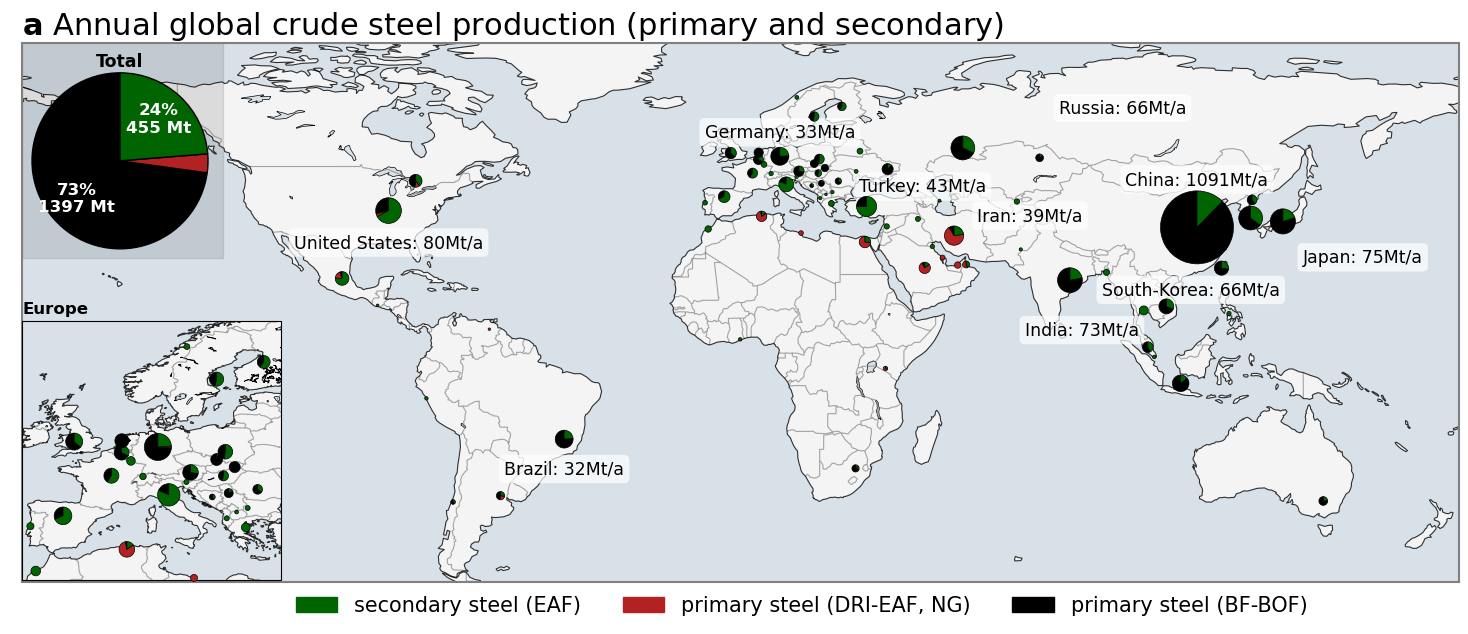

In [39]:
# List of titles and potential columns
titles = [r'$\mathbf{a}$ Annual global crude steel production (primary and secondary)']
pot_cols = ['production volume']

plot_steel_map(results_df, pot_cols, subplot=False, titles = titles, division_bubble=18, amount_show_bubble=30, export_figure='annual_global_steel_production',
               dict_pos = {'Brazil': (-7.5, 0),
                           'Viet Nam': (+17, +23),
                           'Ukraine': (+4, +22),
                        'China': (+12, 0),
                        'Germany': (+6, 0),
                        'India': (-12.5, -3),
                        'Iran, Islamic Republic of': (10, -19),
                        'Iran': (5, -19),
                           'Taiwan': (-12, -19),
                        'Japan': (-9, -20),
                        'South-Korea': (-18, +15),
                        'Russian Federation': (+10, -40),
                        'Türkiye': (+5, -14),
                        'United States': (-8, 0),
                        'Taiwan': (-17, -8),
                           'Egypt': (-14, 0)
                          }, 
              pos_legend_false_subplot = (80, -7.5))

## Plot steel supply curve for current year

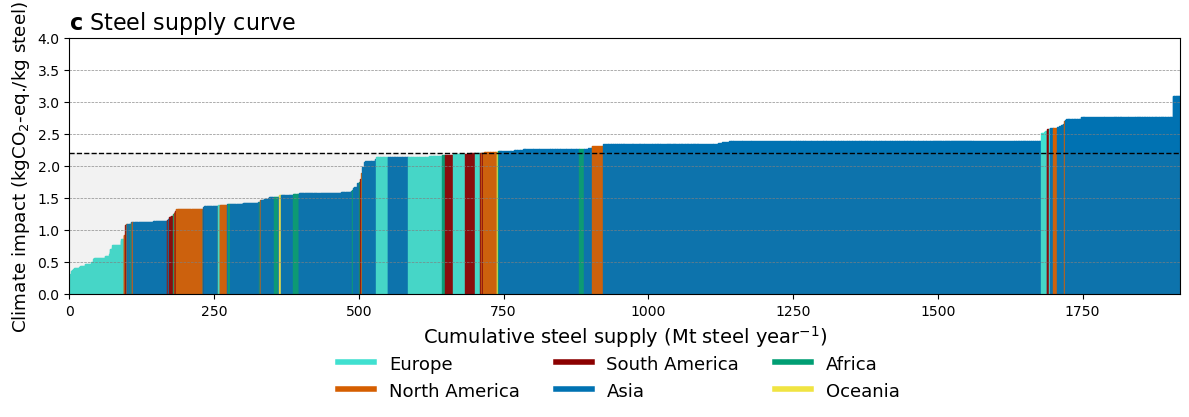

In [40]:
plot_steel_supply_curve(
    results_df=results_df,
    get_continent_func=get_continent,
    color_mapping=dict_color_fig_2_c,
    emission_thresholds={'BF-BOF (2025)': 2.2},
    output_path="figs/steel_supply_curve.png",
    cut_axis_lim = 4,
    zoom=False,
)

In [41]:
summed_results_df = results_df.groupby(['country']).sum()
summed_results_df['share_cbam_covered_weighted'] = summed_results_df['cbam_true_total_cc'] / ( summed_results_df['cbam_true_total_cc'] + summed_results_df['cbam_false_total_cc'] )
summed_results_df['share_cbam_covered_weighted'].sort_values()

country
NO    0.216592
AL    0.266693
BY    0.283537
CH    0.295566
LU    0.359533
        ...   
EG    0.727313
DZ    0.739179
AE    0.755698
BH    0.756507
SA    0.768254
Name: share_cbam_covered_weighted, Length: 73, dtype: float64

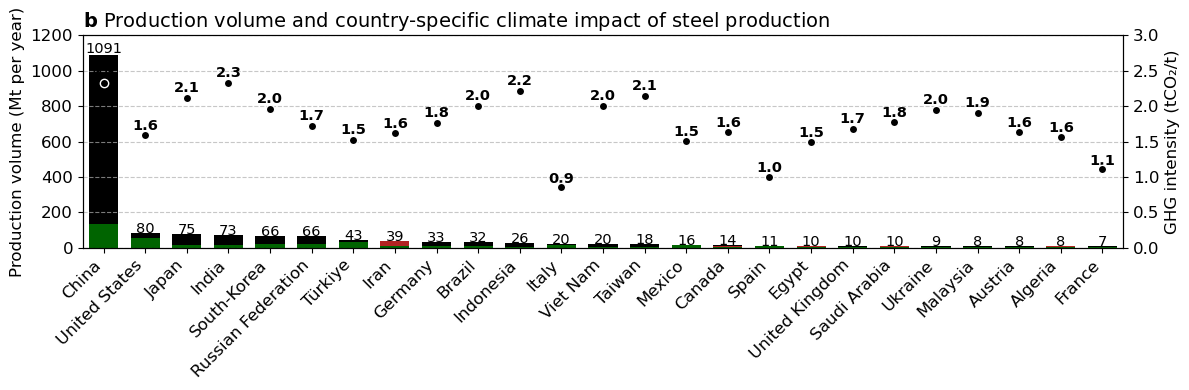

In [42]:
for col in ['production volume']:
    plot_steel_production(results_df, production_col=col, export_figure='prod_fig_intensity')

c:\Users\terlouw_t\.conda\envs\bw_reg_prem\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
c:\Users\terlouw_t\.conda\envs\bw_reg_prem\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


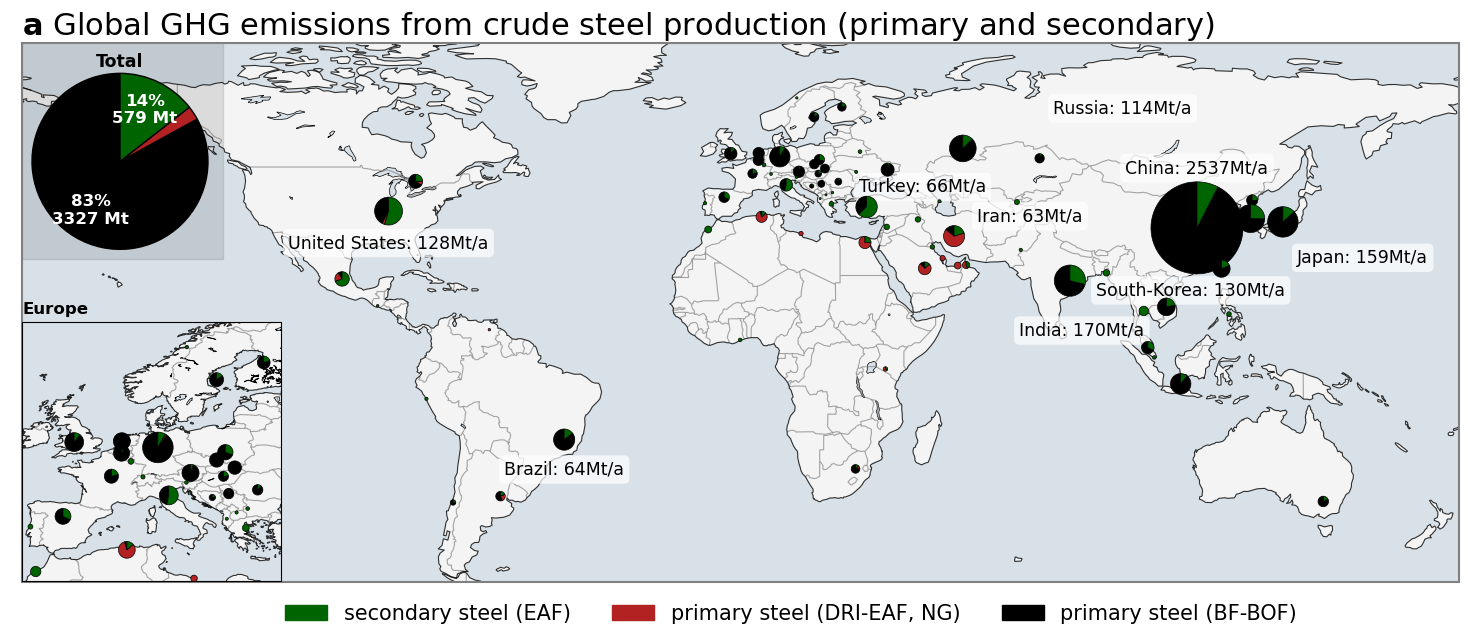

In [43]:
# List of titles and potential columns
titles = ['$\mathbf{a}$ Global GHG emissions from crude steel production (primary and secondary)']

name_to_assess = "Plant_GHG_emissions_Mt_wo_transport"
pot_cols = [name_to_assess]
plot_steel_map(results_df, pot_cols, subplot=False, titles = titles, division_bubble=20, amount_show_bubble=60, export_figure='annual_global_steel_emissions',
               dict_pos = {'Brazil': (-7.5, 0),
                           'Viet Nam': (+17, +23),
                           'Ukraine': (+4, +22),
                        'China': (+15, 0),
                        'Germany': (+6, 0),
                        'India': (-12.5, -3),
                        'Iran, Islamic Republic of': (10, -19),
                        'Iran': (5, -19),
                           'Taiwan': (-12, -19),
                        'Japan': (-9, -20),
                        'South-Korea': (-18, +15),
                        'Russian Federation': (+10, -40),
                        'Türkiye': (+5, -14),
                        'United States': (-8, 0),
                        'Taiwan': (-17, -8),
                           'Egypt': (-14, 0)
                          }, 
              pos_legend_false_subplot = (65, -6.5))

In [44]:
results_df["Plant_GHG_emissions_Mt_wo_transport"].sum(),results_df["production volume"].sum()

(4009.170130187395, 1918.2180000000003)

### Check CBAM coverage for all available (low-carbon) steel production pathways

In [45]:
file_path = "results/results_df_ind.pkl"

columns = ['name', 'year', 'unit', 'location', 'reference product', "database"]
columns.extend([f"lca_impact_{method[1]}" for method in MY_METHODS]) # for lca impcats of the h2 facilities
columns.extend([f"lca_impact_contri_{method[1]}" for method in MY_METHODS if 'climate change' in str(method)]) # for lca impcats of the h2 facilities

results_df_ind = pd.DataFrame(columns=columns) #initialize df to store data in
ei_dbs = [db for db in bd.databases if NAME_REF_DB in str(db) or 'ecoinvent_image' in str(db) ]
                    
# Loop over activities and calculate LCA impacts for each method
if calc_lca_impacts_ind:
    for db in tqdm(ei_dbs):
        steel_activities = [ act for act in bd.Database(db) 
                             if ', with transport' not in act['name'] and ( ('steel production, unalloyed' in act['name'] and
                             'GLO' == act['location']) or ('steel production, converter, unalloyed, only primary steel' in act['name'] and
                             act['location'] in ['RoW', 'World']) or ('primary steel, using direct reduced iron' in act['name'] and
                             act['location'] in ['RoW', 'World']) or ('steel production, electric, low-alloyed, secondary steel, using scrap iron' in act['name'] and
                             act['location'] in ['RoW', 'World']) )] 

        for i, act_sel in enumerate(steel_activities):
            db_name_exch = ""
    
            lca_scores = {}
            lca_scores_contri = {}
    
            for method in MY_METHODS:
                # Initialize LCA for the first method or reuse for subsequent methods
                if i == 0:
                    lca = bw.LCA({act_sel: 1}, method=method)
                    lca.lci()
                    lca.lcia()
                else:
                    if len(MY_METHODS)>1:
                        lca.switch_method(method)
                    lca.redo_lcia({act_sel: 1})
    
                # we need to annotate scope and cbam included info:
                annotate_act_exchanges_with_cbam(act_sel, define_scope_cbam_func=define_scope_cbam,
                                                cbam_precursors_excl=CBAM_RELEVANT_PRECURSORS_STEEL)
                
                # Store the score for the current method
                lca_scores[f'lca_impact_{method[1]}'] = lca.score
    
                if 'climate change' in str(method):
                    result_array = []
                    for exc in act_sel.exchanges():
                        #print(exc['name'])
                        if exc['type'] == 'technosphere':
                            lca.redo_lcia({exc.input: exc['amount']})
                            result_array.append((exc['name'], lca.score, exc['scope'], exc['cbam'], exc['amount']))
                        elif exc['type'] == 'biosphere':
                            # Multiply amount by its CF
                            cf = lca.characterization_matrix[lca.biosphere_dict[exc.input], :].sum()
                            result_array.append((exc['name'], cf * exc['amount'], exc['scope'], exc['cbam'], exc['amount']))
        
                    lca_scores_contri[f'lca_impact_contri_{method[1]}'] = result_array
    
            result = {
                'name': act_sel['name'],
                'reference product': act_sel['reference product'],
                'location': act_sel['location'],
                'unit': act_sel['unit'],
                "database": act_sel['database'],
                'comment': act_sel['comment'],
            }
        
            # update the result dictionary with lca scores
            result.update(lca_scores)
            result.update(lca_scores_contri)

            # Convert the result to a DataFrame
            result_df = pd.DataFrame([result])

            # Determine scope of emissions as well as cbam:
            result_df[['Scope 1', 'Scope 2', 'Scope 3']] = result_df[
                'lca_impact_contri_climate change'].apply(sum_scope_contributions).apply(pd.Series)
            
            result_df[['cbam_true', 'cbam_false']] = result_df[
                'lca_impact_contri_climate change'].apply(sum_cbam_contributions, alpha=alpha 
                                                          if db == NAME_REF_DB else alpha_fut).apply(pd.Series)
            
            result_df[['cbam_true_exclude_scope_2', 'cbam_false_exclude_scope_2']] = result_df[
                'lca_impact_contri_climate change'].apply(sum_cbam_contributions, alpha=alpha 
                                                          if db == NAME_REF_DB else alpha_fut, exclude_scope_2=True).apply(pd.Series)
        
            # Concatenate the result DataFrame with the main DataFrame
            results_df_ind = pd.concat([results_df_ind, result_df], ignore_index=True)

    # Save the DataFrame as a pickle file
    results_df_ind.to_pickle(file_path)
else:
    with open(file_path, 'rb') as file:
        results_df_ind = pickle.load(file)
results_df_ind     

name year      unit location  \
0             BF-BOF+CCS, steel production, unalloyed  NaN  kilogram      GLO   
1   steel production, electric, low-alloyed, prima...  NaN  kilogram      RoW   
2             NG-DRI-EAF, steel production, unalloyed  NaN  kilogram      GLO   
3   steel production, converter, unalloyed, only p...  NaN  kilogram      RoW   
4         TGR-BF-BOF+CCS, steel production, unalloyed  NaN  kilogram      GLO   
5         NG-DRI-EAF+CCS, steel production, unalloyed  NaN  kilogram      GLO   
6                 EW-EAF, steel production, unalloyed  NaN  kilogram      GLO   
7   steel production, electric, low-alloyed, secon...  NaN  kilogram      RoW   
8             TGR-BF-BOF, steel production, unalloyed  NaN  kilogram      GLO   
9             H2-DRI-EAF, steel production, unalloyed  NaN  kilogram      GLO   
10        NG-DRI-EAF+CCS, steel production, unalloyed  NaN  kilogram      GLO   
11                EW-EAF, steel production, unalloyed  NaN  kilogram      GLO   
12  steel production, electric, low-alloyed, prima...  NaN  kilogram    World   
13            TGR-BF-BOF, steel production, unalloyed  NaN  kilogram      GLO   
14        TGR-BF-BOF+CCS, steel production, unalloyed  NaN  kilogram      GLO   
15            NG-DRI-EAF, steel production, unalloyed  NaN  kilogram      GLO   
16  steel production, converter, unalloyed, only p...  NaN  kilogram    World   
17            BF-BOF+CCS, steel production, unalloyed  NaN  kilogram      GLO   
18  steel production, electric, low-alloyed, secon...  NaN  kilogram    World   
19            H2-DRI-EAF, steel production, unalloyed  NaN  kilogram      GLO   
20            NG-DRI-EAF, steel production, unalloyed  NaN  kilogram      GLO   
21  steel production, electric, low-alloyed, secon...  NaN  kilogram    World   
22            TGR-BF-BOF, steel production, unalloyed  NaN  kilogram      GLO   
23  steel production, converter, unalloyed, only p...  NaN  kilogram    World   
24  steel production, electric, low-alloyed, prima...  NaN  kilogram    World   
25            BF-BOF+CCS, steel production, unalloyed  NaN  kilogram      GLO   
26                EW-EAF, steel production, unalloyed  NaN  kilogram      GLO   
27        TGR-BF-BOF+CCS, steel production, unalloyed  NaN  kilogram      GLO   
28        NG-DRI-EAF+CCS, steel production, unalloyed  NaN  kilogram      GLO   
29            H2-DRI-EAF, steel production, unalloyed  NaN  kilogram      GLO   
30                EW-EAF, steel production, unalloyed  NaN  kilogram      GLO   
31  steel production, electric, low-alloyed, prima...  NaN  kilogram    World   
32        NG-DRI-EAF+CCS, steel production, unalloyed  NaN  kilogram      GLO   
33            NG-DRI-EAF, steel production, unalloyed  NaN  kilogram      GLO   
34            TGR-BF-BOF, steel production, unalloyed  NaN  kilogram      GLO   
35        TGR-BF-BOF+CCS, steel production, unalloyed  NaN  kilogram      GLO   
36  steel production, electric, low-alloyed, secon...  NaN  kilogram    World   
37            H2-DRI-EAF, steel production, unalloyed  NaN  kilogram      GLO   
38  steel production, converter, unalloyed, only p...  NaN  kilogram    World   
39            BF-BOF+CCS, steel production, unalloyed  NaN  kilogram      GLO   
40            TGR-BF-BOF, steel production, unalloyed  NaN  kilogram      GLO   
41        NG-DRI-EAF+CCS, steel production, unalloyed  NaN  kilogram      GLO   
42  steel production, electric, low-alloyed, prima...  NaN  kilogram    World   
43            H2-DRI-EAF, steel production, unalloyed  NaN  kilogram      GLO   
44                EW-EAF, steel production, unalloyed  NaN  kilogram      GLO   
45        TGR-BF-BOF+CCS, steel production, unalloyed  NaN  kilogram      GLO   
46  steel production, converter, unalloyed, only p...  NaN  kilogram    World   
47  steel production, electric, low-alloyed, secon...  NaN  kilogram    World   
48            BF-BOF+CCS, steel production, unalloyed  NaN  kilogram      GLO   

In [46]:
results_df_ind.iloc[8]

name                                          TGR-BF-BOF, steel production, unalloyed
year                                                                              NaN
unit                                                                         kilogram
location                                                                          GLO
reference product                                         TGR-BF-BOF steel, unalloyed
database                                                      ecoinvent_310_reference
lca_impact_climate change                                                    2.094455
lca_impact_co2 emissions                                                     1.904997
lca_impact_contri_climate change    [(TGR-BF, iron production, 1.8793257439170752,...
comment                             < This dataset is from ecoinvent, modified by ...
Scope 1                                                                      0.062709
Scope 2                                               

In [47]:
# Convert to DataFrame
data_x = results_df_ind.iloc[8]['lca_impact_contri_climate change']
df_x = pd.DataFrame(data_x, columns=['Exchange', 'Climate impact', 'Scope', 'CBAM', 'Amount'])
#df_x['spec_impact [kgCO2-eq./FU exchange]'] = df_x['Climate impact']/df_x['Amount']
df_x

Exchange  Climate impact  Scope  \
0                             TGR-BF, iron production        1.879326      3   
1                market for basic oxygen furnace dust        0.001295      3   
2   market for basic oxygen furnace secondary meta...        0.000000      3   
3                market for basic oxygen furnace slag        0.031167      3   
4              market for basic oxygen furnace sludge        0.000027      3   
5           market for blast oxygen furnace converter        0.002835      3   
6                                     market for coke        0.000006      3   
7            market for compressed air, 600 kPa gauge        0.000719      3   
8                                 market for dolomite        0.000297      3   
9        market group for electricity, medium voltage        0.007850      2   
10     market for ferromanganese, high-coal, 74.5% Mn        0.017845      3   
11         market for inert waste, for final disposal        0.000006      3   
12                    market for iron ore concentrate        0.000061      3   
13             market for iron scrap, sorted, pressed        0.000000      3   
14                              market for mill scale        0.000025      3   
15        market group for natural gas, high pressure        0.000730      3   
16              market for natural gas, high pressure        0.000006      3   
17                          market for oxygen, liquid        0.036410      3   
18                                market for pig iron        0.000000      3   
19             market for quicklime, in pieces, loose        0.052905      3   
20     market for wastewater from pig iron production        0.000181      3   
21     market for wastewater from pig iron production        0.000054      3   
22                             Carbon dioxide, fossil        0.062709      1   
23                            Carbon monoxide, fossil        0.000000      1   
24                                       Chromium III        0.000000      1   
25                                         Copper ion        0.000000      1   
26  Dioxins, measured as 2,3,7,8-tetrachlorodibenz...        0.000000      1   
27                                        Heat, waste        0.000000      1   
28                                           Iron ion        0.000000      1   
29                                            Lead II        0.000000      1   
30                                       Manganese II        0.000000      1   
31                                    Nitrogen oxides        0.000000      1   
32              PAH, polycyclic aromatic hydrocarbons        0.000000      1   
33                       Particulate Matter, < 2.5 um        0.000000      1   
34                                              Water        0.000000      1   
35         Water, cooling, unspecified natural origin        0.000000      1   

     CBAM        Amount  
0    True  1.096731e+00  
1   False -1.939600e-02  
2   False  0.000000e+00  
3   False -1.051984e-01  
4   False -3.008000e-04  
5   False  1.333300e-11  
6   False  1.832160e-04  
7   False  1.442221e-02  
8   False  4.422177e-03  
9    True  2.415231e-02  
10   True  6.000000e-03  
11  False -5.656850e-04  
12  False  6.228965e-04  
13  False  0.000000e+00  
14  False -6.630000e-05  
15  False  1.194474e-03  
16  False  7.712214e-06  
17  False  7.805400e-02  
18   True  0.000000e+00  
19  False  4.483302e-02  
20  False -1.032678e-03  
21  False -3.089630e-04  
22   True  6.270885e-02  
23   True  1.682141e-03  
24   True  2.738613e-08  
25   True  1.386842e-07  
26   True  6.357673e-14  
27   True  2.046962e-01  
28   True  4.115000e-05  
29   True  4.081666e-07  
30   True  6.841053e-07  
31   True  2.123676e-05  
32   True  1.000000e-08  
33   True  4.474371e-05  
34   True  6.118409e-03  
35   True  5.775812e-03

# Plot the result for Figure 4

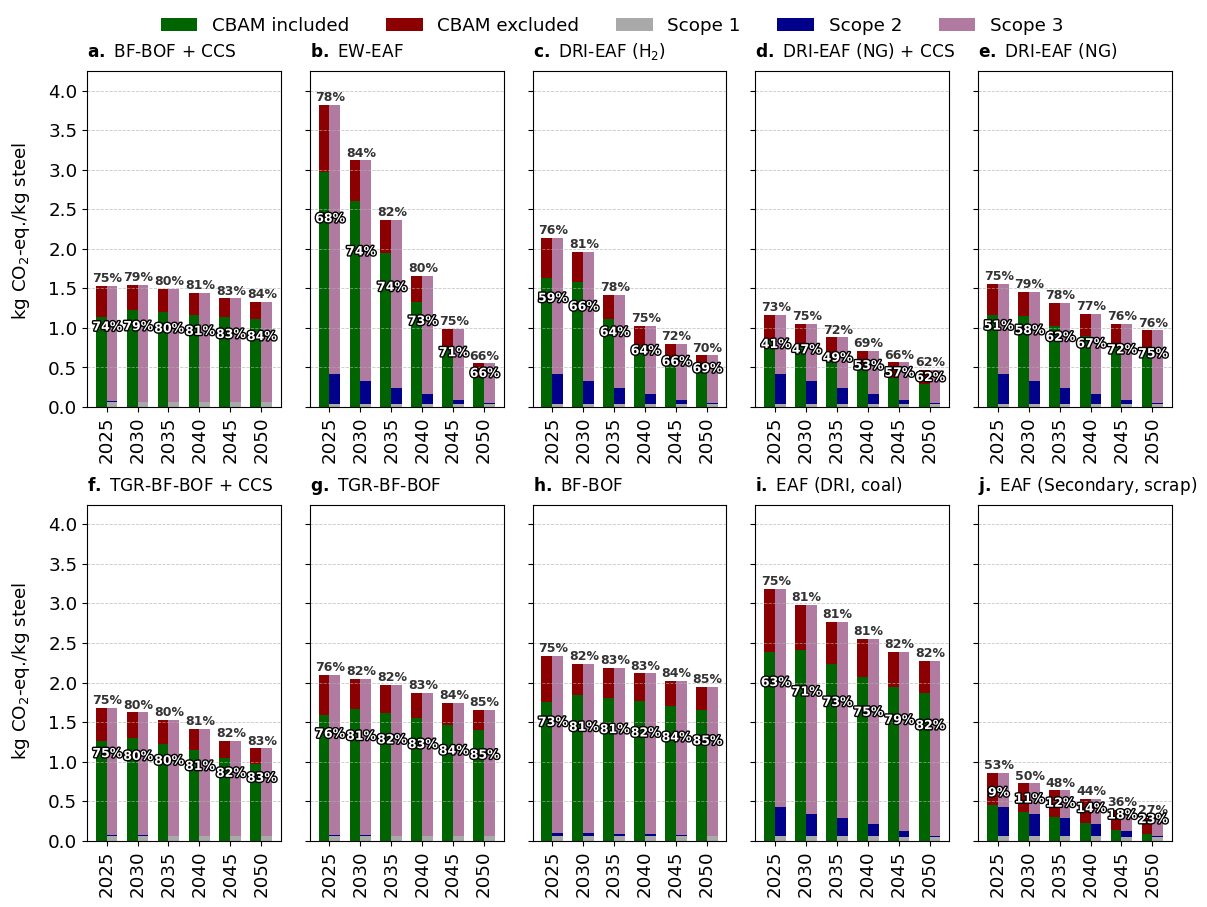

In [48]:
name_mapping_techs = {
    'TGR-BF-BOF+CCS, steel production, unalloyed': 'TGR-BF-BOF + CCS',
    'EW-EAF, steel production, unalloyed': 'EW-EAF',
    'steel production, converter, unalloyed, only primary steel': 'BF-BOF',
    'NG-DRI-EAF, steel production, unalloyed': 'DRI-EAF (NG)',
    'H2-DRI-EAF, steel production, unalloyed': 'DRI-EAF (H$_2$)',
    'steel production, electric, low-alloyed, secondary steel, using scrap iron': 'EAF (Secondary, scrap)',
    'NG-DRI-EAF+CCS, steel production, unalloyed': 'DRI-EAF (NG) + CCS',
    'steel production, electric, low-alloyed, primary steel, using direct reduced iron': 'EAF (DRI, coal)',
    'TGR-BF-BOF, steel production, unalloyed': 'TGR-BF-BOF',
    'BF-BOF+CCS, steel production, unalloyed': 'BF-BOF + CCS'
}

plot_cbam_scope_stacked(
    results_df_ind=results_df_ind,
    ei_dbs=ei_dbs,
    db_label_map=db_label_map,
    name_mapping_techs=name_mapping_techs
)

results_df_ind[['cbam_true_efactor', 'cbam_false_efactor']] = results_df_ind[
    'lca_impact_contri_climate change'].apply(sum_cbam_contributions_emission_factor, alpha=alpha_fut).apply(pd.Series)

plot_cbam_scope_stacked(
    results_df_ind=results_df_ind,
    ei_dbs=ei_dbs,
    db_label_map=db_label_map,
    name_mapping_techs=name_mapping_techs,
    name_cbam_true='cbam_true_efactor',
    name_cbam_false='cbam_false_efactor',
    output_path='figs/steel_cbam_scope_stacked_efactor.png',
)

___
### 9. Prospective analysis for different scenarios (IMAGE IAM Background scenario):

Five scenarios in 2C world:
* Plants with secondary EAF wth carbon capture and CO2 storage
* Plants with secondary EAF with H2-DRI
* Plants with secondary EAF with H2-DRI (only using low-carbon hydrogen via solar PV)
* Plants with secondary EAF with EW (elecrification)
* Plants with secondary EAF with EW (elecrification, only low-carbon solar PV power)

Also, we filter out older plants and integrate all low-carbon projects provided in https://www.industrytransition.org/green-steel-tracker/

In [49]:
plants_mod_future['Capacity operating status'].unique()

array(['Announced', 'Construction', 'Operating',
       'Finalized (research & testing)', 'operating',
       'operating pre-retirement', 'mothballed', 'retired',
       'construction', 'announced', 'cancelled'], dtype=object)

In [50]:
valid_future_statuses = [
    'Operating', 'operating',
    'Announced', 'announced',
    'Construction', 'construction',
    'Finalized (research & testing)'
]

plants_mod_future = plants_mod_future[
    plants_mod_future['Capacity operating status'].isin(valid_future_statuses)
]
plants_mod_future['Capacity operating status'].value_counts()

Capacity operating status
operating                         783
Announced                          33
announced                          27
Construction                       13
construction                       11
Operating                           3
Finalized (research & testing)      3
Name: count, dtype: int64

In [51]:
start_year = 1950 #exclude plants where years are before this one
plants_mod_future = plants_mod_future[ (plants_mod_future['Start date']>start_year) & (plants_mod_future['Start date']<=FUTURE_YEAR) ]
plants_mod_future['Start date'].describe()

count     723.000000
mean     1996.835408
std        20.743634
min      1951.000000
25%      1982.000000
50%      2001.000000
75%      2012.000000
max      2033.000000
Name: Start date, dtype: float64

In [52]:
image_file = pd.read_excel(r"data\full data\image_SSP2-RCP26.xlsx")
image_file_steel = image_file[ (image_file['Variable'].str.contains('Production|Industry|Iron and Steel', regex=False) ) & 
            (image_file['Region']!='World') ]
scrap_primary = image_file_steel[ (image_file_steel['Variable'] == 'Production|Industry|Iron and Steel|EAF scrap') | (image_file_steel['Variable'] == 'Production|Industry|Iron and Steel|Primary')]
scrap_primary.groupby("Variable").sum()[str(FUTURE_YEAR)]

Variable
Production|Industry|Iron and Steel|EAF scrap     702.041904
Production|Industry|Iron and Steel|Primary      1446.449436
Name: 2040, dtype: float64

In [53]:
scrap_primary.groupby("Variable").sum()[str(FUTURE_YEAR)].sum()

2148.4913406074047

In [54]:
primary_steel_image_future = 1446.449436 #image_SSP2-RCP26.
secondary_steel_image_future = 702.041904 #image_SSP2-RCP26.

In [55]:
primary_steel_image_future/(primary_steel_image_future+secondary_steel_image_future)

0.6732395933231922

In [56]:
factor_sec = secondary_steel_image_future/plants_mod_future['EAF steel production'].sum()
plants_mod_future['EAF steel production'] *= factor_sec
plants_mod_future['EAF steel production'].sum()

702.041904

In [57]:
cols_prim = ['BOF steel production',
 #'EAF steel production',
 'EAF steel production (DRI, coal)',
 'EAF steel production (DRI, NG)',
 'OHF steel production',
 #'BF production',
 #'DRI production',
'steel production']

factor = primary_steel_image_future/plants_mod_future[cols_prim].sum().sum()

plants_mod_future[cols_prim] = plants_mod_future[cols_prim].multiply(factor)
plants_mod_future[cols_prim].sum(),plants_mod_future[cols_prim].sum().sum()

(BOF steel production                1324.681463
 EAF steel production (DRI, coal)       0.842857
 EAF steel production (DRI, NG)        74.267884
 OHF steel production                   0.000000
 steel production                      46.657231
 dtype: float64,
 1446.4494360000003)

___
### 9.1 Prospective analyses
### Now, we will have to make some assumptions about the future of steel production, we take the IMAGE 2C model


In [58]:
from set_up_config import CaseConfig, run_case, make_build_caches

def transform_ew_lc(plants: pd.DataFrame) -> pd.DataFrame:
    out = plants.copy()
    out["power_classification"] = "renewable"
    return out

def transform_h2dri_lc(plants: pd.DataFrame) -> pd.DataFrame:
    out = plants.copy()
    out["power_classification"] = "renewable" # this also ensures that we only make low-carbon electrolytic hydrogen using solar PV
    return out

CASES = [
    CaseConfig(
        key="future_h2dri",
        steel_method="",
        db_name_out="steel_db_future",
        dict_acts=dict_acts_future_dri,
        create_db=create_new_steel_db_future,
        calc_lca=calc_lca_impacts_future,
        contri=contri_future,
        plants_transform=None,
    ),
    CaseConfig(
        key="future_h2dri_lc",
        steel_method="lc",
        db_name_out="steel_db_future_lc",
        dict_acts=dict_acts_future_dri,
        create_db=create_new_steel_db_future_lc,
        calc_lca=calc_lca_impacts_future_lc,
        contri=contri_future_lc,
        plants_transform=transform_h2dri_lc,
    ),
    CaseConfig(
        key="future_ccs",
        steel_method="ccs",
        db_name_out="steel_db_future_ccs",
        dict_acts=dict_acts_future_ccs,
        create_db=create_new_steel_db_future_ccs,
        calc_lca=calc_lca_impacts_future_ccs,
        contri=contri_future_ccs,
        plants_transform=None,
    ),
    CaseConfig(
        key="future_ew",
        steel_method="ew",
        db_name_out="steel_db_future_ew",
        dict_acts=dict_acts_future_ew,
        create_db=create_new_steel_db_future_ew,
        calc_lca=calc_lca_impacts_future_ew,
        contri=contri_future_ew,
        plants_transform=None,
    ),
    CaseConfig(
        key="future_ew_lc",
        steel_method="ew_lc",
        db_name_out="steel_db_future_ew_lc",
        dict_acts=dict_acts_future_ew,      # same matching dict, only plants differ
        create_db=create_new_steel_db_future_ew_lc,
        calc_lca=calc_lca_impacts_future_ew_lc,
        contri=contri_future_ew_lc,
        plants_transform=transform_ew_lc,
    ),
]


In [59]:
db_name

'steel_db'

In [60]:
# 0) One-time cleaning of plants (do this once)
plants_mod_future = plants_mod_future[
    ~plants_mod_future["steel_or_iron_production"].str.contains("iron", case=False, na=False)
].copy()

results = {}
caches = None  # <-- only build when needed

for case in CASES:
    print(case.key, case.create_db)

    if case.create_db:
        # Build caches only once, only if we actually need to build a DB
        if caches is None:
            caches = make_build_caches(
                w=w,
                NAME_REF_DB=NAME_REF_DB,
                BIOSPHERE_DB=BIOSPHERE_DB,
                future_db_name="ecoinvent_image_SSP2-RCP26_2040_base",
                FUTURE_YEAR=FUTURE_YEAR,
                match_year_to_database=match_year_to_database,
            )

        results[case.key] = run_case(
            plants_future=plants_mod_future,
            case=case,
            caches=caches,
            bw=bw,
            db_name_base=db_name,
            process_import=process_import,
            annotate_exchanges_with_cbam=annotate_exchanges_with_cbam,
            define_scope_cbam=define_scope_cbam,
            #CBAM_RELEVANT_PRECURSORS_EXCL=CBAM_RELEVANT_PRECURSORS_EXCL,
            create_regionalized_activity=create_regionalized_activity,
            process_exchanges=process_exchanges,
            add_transport_exchanges=add_transport_exchanges,
            match_year_to_database=match_year_to_database,
            country_to_iso2=country_to_iso2,
            calc_lca_impacts_all_plants=calc_lca_impacts_all_plants,
            MY_METHODS=MY_METHODS,
            european_countries=european_countries,
            dict_types=dict_types,
            sum_exchanges_wo_transport=sum_exchanges_wo_transport,
            time_tag="future",
            alpha=alpha_fut,
            sum_scope_contributions=sum_scope_contributions,
            sum_cbam_contributions=sum_cbam_contributions,
            sum_cbam_contributions_emission_factor=sum_cbam_contributions_emission_factor,
        )

    else:
        # Load results_df from pickle (no caches, no bw db build)
        results[case.key] = calc_lca_impacts_all_plants(
            steel_method=case.steel_method,
            db_name_base="steel_db",
            methods=MY_METHODS,
            calc_lca_impacts=False,   # <-- load
            contri=case.contri,
            start_idx=0,
            european_countries=european_countries,
            dict_types=dict_types,
            sum_exchanges_wo_transport=sum_exchanges_wo_transport,
            time_tag="future",
        )

# Convenience variables
results_df_future_dri      = results["future_h2dri"]
results_df_future_dri_lc   = results["future_h2dri_lc"]
results_df_future_ccs  = results["future_ccs"]
results_df_future_ew   = results["future_ew"]
results_df_future_ew_lc= results["future_ew_lc"]


future_h2dri False
future_h2dri_lc False
future_ccs False
future_ew False
future_ew_lc False


In [61]:
results["future_h2dri_lc"]

name  year      unit  \
595  H2-DRI-EAF, steel production, unalloyed for fa...  2040  kilogram   
550  H2-DRI-EAF, steel production, unalloyed for fa...  2040  kilogram   
543  H2-DRI-EAF, steel production, low-alloyed for ...  2040  kilogram   
235  steel production, electric, low-alloyed for fa...  2040  kilogram   
9    H2-DRI-EAF, steel production, unalloyed for fa...  2040  kilogram   
..                                                 ...   ...       ...   
386  steel production, electric, low-alloyed for fa...  2040  kilogram   
197  steel production, electric, low-alloyed for fa...  2040  kilogram   
548  steel production, electric, low-alloyed for fa...  2040  kilogram   
432  steel production, electric, low-alloyed for fa...  2040  kilogram   
281  H2-DRI-EAF, steel production, unalloyed for fa...  2040  kilogram   

    country location              reference product  production volume  \
595      CN       CN    H2-DRI-EAF steel, unalloyed             84.780   
550      CN       CN    H2-DRI-EAF steel, unalloyed             79.983   
543      CN       CN  H2-DRI-EAF steel, low-alloyed             41.914   
235      IN       IN             steel, low-alloyed             11.670   
9        CN       CN    H2-DRI-EAF steel, unalloyed             31.873   
..      ...      ...                            ...                ...   
386      IT       IT             steel, low-alloyed              0.737   
197      PT       PT             steel, low-alloyed              0.737   
548      FR       FR             steel, low-alloyed              0.614   
432      IT       IT             steel, low-alloyed              0.614   
281      AT       AT    H2-DRI-EAF steel, unalloyed              0.005   

               database                               initial name  \
595  steel_db_future_lc    H2-DRI-EAF, steel production, unalloyed   
550  steel_db_future_lc    H2-DRI-EAF, steel production, unalloyed   
543  steel_db_future_lc  H2-DRI-EAF, steel production, low-alloyed   
235  steel_db_future_lc    steel production, electric, low-alloyed   
9    steel_db_future_lc    H2-DRI-EAF, steel production, unalloyed   
..                  ...                                        ...   
386  steel_db_future_lc    steel production, electric, low-alloyed   
197  steel_db_future_lc    steel production, electric, low-alloyed   
548  steel_db_future_lc    steel production, electric, low-alloyed   
432  steel_db_future_lc    steel production, electric, low-alloyed   
281  steel_db_future_lc    H2-DRI-EAF, steel production, unalloyed   

                                               comment  ...   longitude  \
595  < This dataset is from ecoinvent, modified by ...  ...  112.897377   
550  < This dataset is from ecoinvent, modified by ...  ...  111.967343   
543  < This dataset is from ecoinvent, modified by ...  ...  115.184798   
235  Geography:  Data collected from integrated ste...  ...   72.647304   
9    < This dataset is from ecoinvent, modified by ...  ...  120.638992   
..                                                 ...  ...         ...   
386  This dataset has been modified by `premise`, a...  ...    7.944998   
197  This dataset has been modified by `premise`, a...  ...   -8.555285   
548  This dataset has been modified by `premise`, a...  ...    3.561712   
432  This dataset has been modified by `premise`, a...  ...   15.032870   
281  < This dataset is from ecoinvent, modified by ...  ...   14.334340   

     power_source lca_impact_climate change  lca_impact_co2 emissions  \
595     renewable                  0.682315                  0.690018   
550     renewable                  0.682315                  0.690018   
543     renewable                  1.027930                  1.057386   
235     renewable                  2.131960                  2.075277   
9       renewable                  0.682315                  0.690018   
..            ...                       ...                       ...   
386     renewable  

In [62]:
res = sum_electricity_and_hydrogen_from_db(
    db_name="steel_db_future",
    bw=bw,
    h2_electricity_factor_kWh_per_kg=(120/3.6/0.662),  # electrolysis assumption
)

print(f"Electricity demand: {res['electricity_TWh']:.1f} TWh")
print(f"Hydrogen demand: {res['hydrogen_Mt']:.2f} Mt H2")
print(f"Electricity for H2: {res['hydrogen_electricity_TWh']:.1f} TWh")
print(f"Total electricity: {res['total_electricity_TWh']:.1f} TWh")


Electricity demand: 1432.9 TWh
Hydrogen demand: 94.85 Mt H2
Electricity for H2: 4775.8 TWh
Total electricity: 6208.7 TWh


In [63]:
def demand_from_routes(
    df: pd.DataFrame,
    routes: list[str],
    factor_kg_per_kg_steel: float,
    *,
    initial_name_col: str = "initial name",
    production_col: str = "production volume",   # Mt steel
) -> float:
    """
    Returns demand in Mt (same unit as production_col uses Mt steel).
    factor_kg_per_kg_steel e.g. kg H2 per kg steel or kg CO2 stored per kg steel.
    """
    prod_Mt = df[df[initial_name_col].isin(routes)][production_col].sum()  # Mt steel
    prod_kg = prod_Mt * 1e9
    demand_Mt = factor_kg_per_kg_steel * prod_kg / 1e9
    return float(demand_Mt)

# CO2 storage for BF-BOF+CCS (example)
co2_storage_Mt = demand_from_routes(
    results_df_future_ccs,
    routes=[
        "BF-BOF+CCS, steel production, low-alloyed",
        "BF-BOF+CCS, steel production, unalloyed",
    ],
    factor_kg_per_kg_steel=0.7525433761004349,
)

print(f"CO2 storage demand for BF-BOF+CCS in 2040: {co2_storage_Mt:.2f} Mt CO2")

CO2 storage demand for BF-BOF+CCS in 2040: 1059.13 Mt CO2


In [64]:
results_df_future_ew

name  year      unit  \
267  EW-EAF, steel production, unalloyed for facili...  2040  kilogram   
492  EW-EAF, steel production, unalloyed for facili...  2040  kilogram   
268  EW-EAF, steel production, low-alloyed for faci...  2040  kilogram   
566  EW-EAF, steel production, unalloyed for facili...  2040  kilogram   
342  EW-EAF, steel production, low-alloyed for faci...  2040  kilogram   
..                                                 ...   ...       ...   
95   steel production, electric, low-alloyed for fa...  2040  kilogram   
273  EW-EAF, steel production, unalloyed for facili...  2040  kilogram   
556  steel production, electric, low-alloyed for fa...  2040  kilogram   
290  steel production, electric, low-alloyed for fa...  2040  kilogram   
245  H2-DRI-EAF, steel production, unalloyed for fa...  2040  kilogram   

    country location            reference product  production volume  \
267      CN       CN      EW-EAF steel, unalloyed             84.780   
492      CN       CN      EW-EAF steel, unalloyed             79.983   
268      CN       CN    EW-EAF steel, low-alloyed             41.914   
566      CN       CN      EW-EAF steel, unalloyed             18.061   
342      CN       CN    EW-EAF steel, low-alloyed             15.299   
..      ...      ...                          ...                ...   
95       PT       PT           steel, low-alloyed              0.737   
273      VE       VE      EW-EAF steel, unalloyed              0.272   
556      IT       IT           steel, low-alloyed              0.614   
290      FR       FR           steel, low-alloyed              0.614   
245      AT       AT  H2-DRI-EAF steel, unalloyed              0.005   

               database                             initial name  \
267  steel_db_future_ew      EW-EAF, steel production, unalloyed   
492  steel_db_future_ew      EW-EAF, steel production, unalloyed   
268  steel_db_future_ew    EW-EAF, steel production, low-alloyed   
566  steel_db_future_ew      EW-EAF, steel production, unalloyed   
342  steel_db_future_ew    EW-EAF, steel production, low-alloyed   
..                  ...                                      ...   
95   steel_db_future_ew  steel production, electric, low-alloyed   
273  steel_db_future_ew      EW-EAF, steel production, unalloyed   
556  steel_db_future_ew  steel production, electric, low-alloyed   
290  steel_db_future_ew  steel production, electric, low-alloyed   
245  steel_db_future_ew  H2-DRI-EAF, steel production, unalloyed   

                                               comment  ...   longitude  \
267  < This dataset is from ecoinvent, modified by ...  ...  112.897377   
492  < This dataset is from ecoinvent, modified by ...  ...  111.967343   
268  < This dataset is from ecoinvent, modified by ...  ...  115.184798   
566  < This dataset is from ecoinvent, modified by ...  ...  109.379630   
342  < This dataset is from ecoinvent, modified by ...  ...  121.440087   
..                                                 ...  ...         ...   
95   This dataset has been modified by `premise`, a...  ...   -8.555285   
273  < This dataset is from ecoinvent, modified by ...  ...  -62.841126   
556  This dataset has been modified by `premise`, a...  ...   15.032870   
290  This dataset has been modified by `premise`, a...  ...    3.561712   
245  < This dataset is from ecoinvent, modified by ...  ...   14.334340   

     power_source lca_impact_climate change  lca_impact_co2 emissions  \
267          grid                  2.688199                  2.683627   
492          grid                  2.688199                  2.683627   
268          grid                  3.033814                  3.050995   
566          grid                  2.688199                  2.683627   
342          grid                  3.033814                  3.050995   
..            ...                       ...                       ...   
95           grid                  0.207837                  0.2294


SCENARIO: future_h2dri

--- Overall production & emissions ---
Total GHG emissions (w/o transport):     3553.1 Mt CO₂-eq
Total steel production:                   2148.5 Mt
Average emissions intensity:                1.65 kg CO₂-eq/kg

--- Scope breakdown (volume-weighted totals) ---
Scope 1 total:      149.0 Mt CO₂-eq
Scope 2 total:     2093.9 Mt CO₂-eq
Scope 3 total:     1310.1 Mt CO₂-eq

--- CBAM coverage ---
CBAM-covered emissions:         2715.6 Mt CO₂-eq
Non-covered emissions:           837.5 Mt CO₂-eq
Share covered by CBAM:          76.43%
CBAM-covered intensity:           1.26 kg CO₂-eq/kg


c:\Users\terlouw_t\.conda\envs\bw_reg_prem\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
c:\Users\terlouw_t\.conda\envs\bw_reg_prem\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


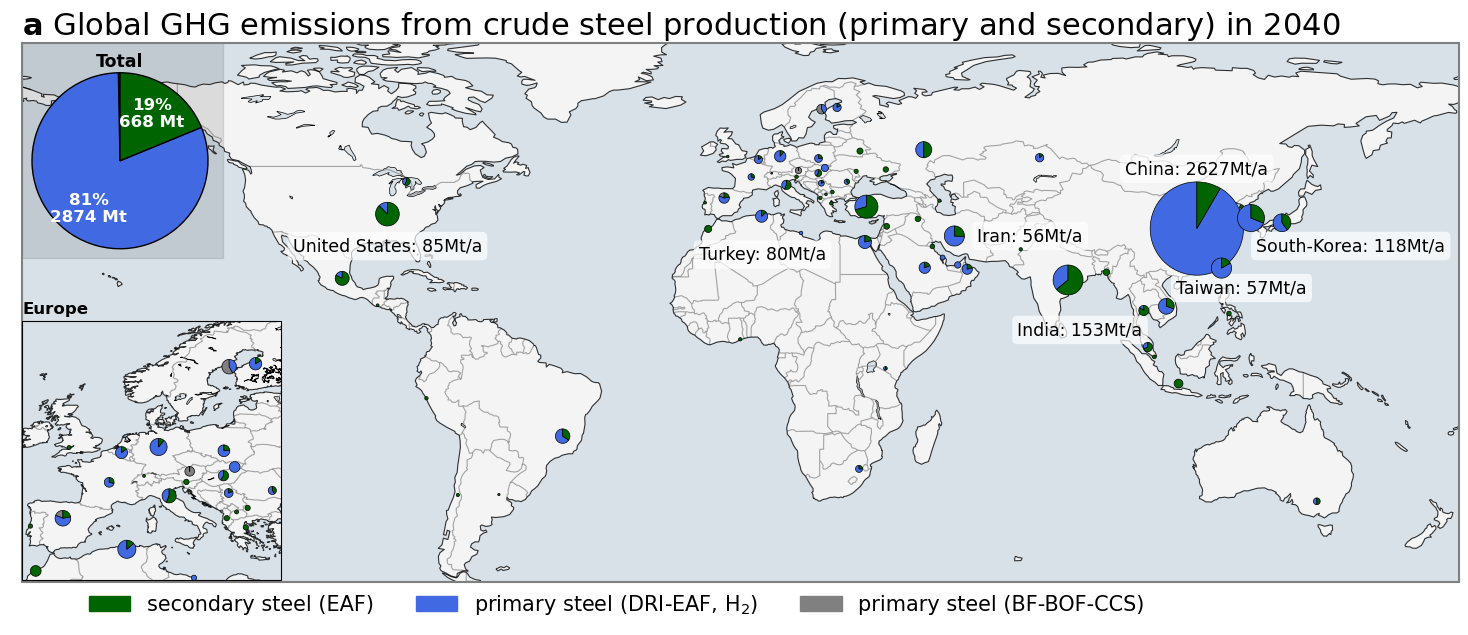

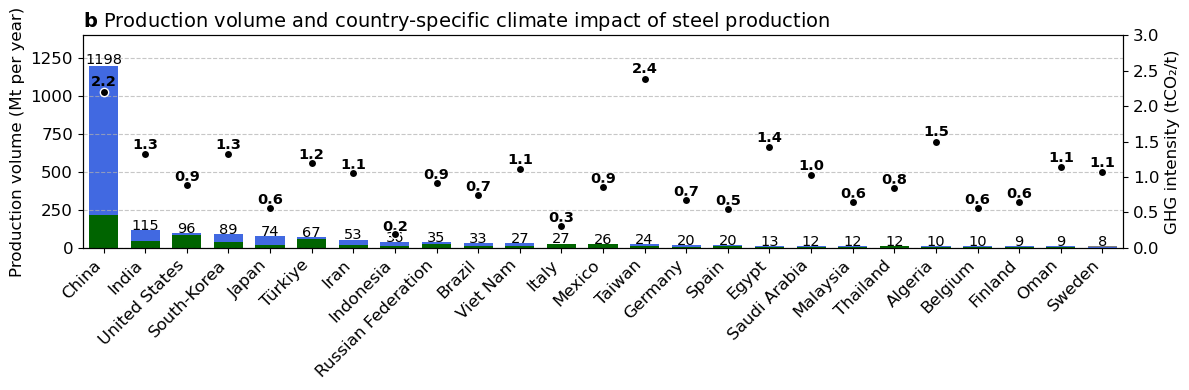


SCENARIO: future_h2dri_lc

--- Overall production & emissions ---
Total GHG emissions (w/o transport):     1666.7 Mt CO₂-eq
Total steel production:                   2148.5 Mt
Average emissions intensity:                0.78 kg CO₂-eq/kg

--- Scope breakdown (volume-weighted totals) ---
Scope 1 total:      149.0 Mt CO₂-eq
Scope 2 total:       49.2 Mt CO₂-eq
Scope 3 total:     1468.5 Mt CO₂-eq

--- CBAM coverage ---
CBAM-covered emissions:          651.5 Mt CO₂-eq
Non-covered emissions:          1015.2 Mt CO₂-eq
Share covered by CBAM:          39.09%
CBAM-covered intensity:           0.30 kg CO₂-eq/kg


c:\Users\terlouw_t\.conda\envs\bw_reg_prem\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
c:\Users\terlouw_t\.conda\envs\bw_reg_prem\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


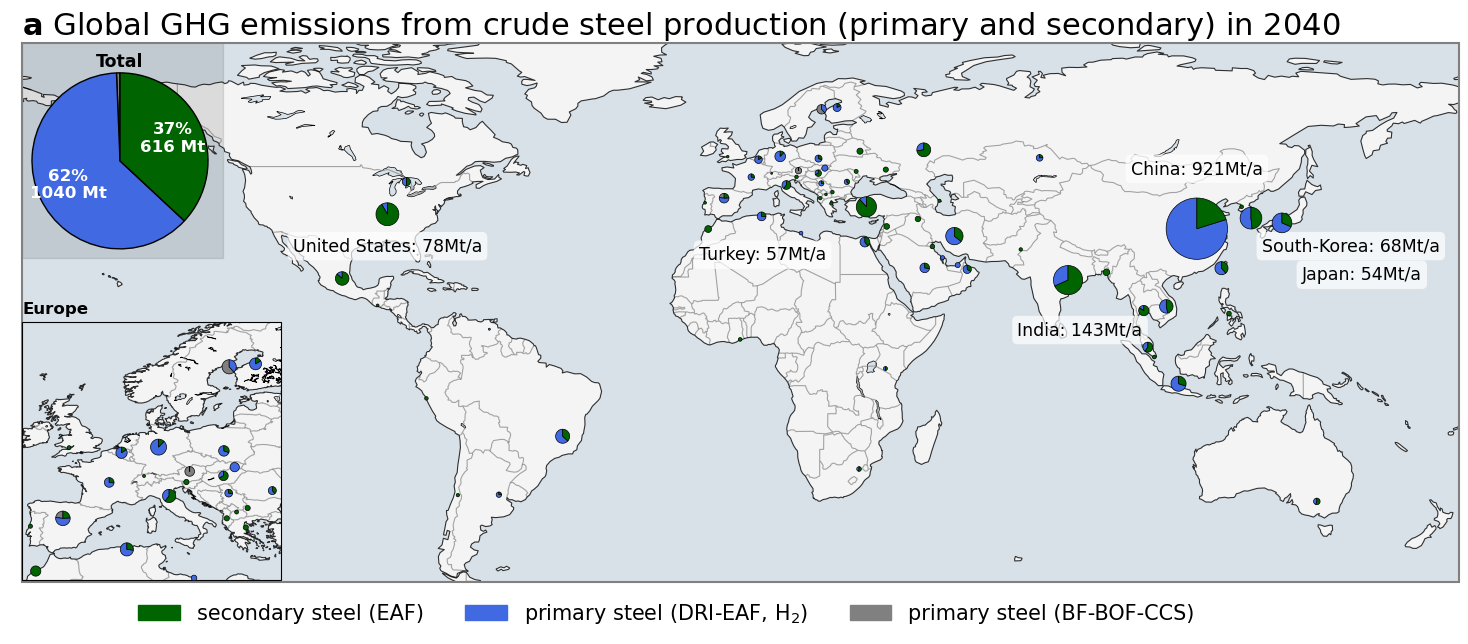

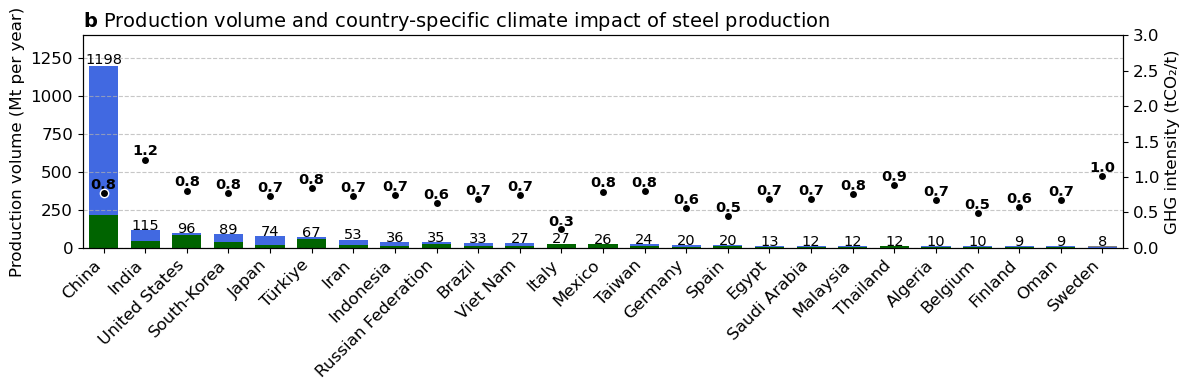


SCENARIO: future_ccs

--- Overall production & emissions ---
Total GHG emissions (w/o transport):     2948.4 Mt CO₂-eq
Total steel production:                   2148.5 Mt
Average emissions intensity:                1.37 kg CO₂-eq/kg

--- Scope breakdown (volume-weighted totals) ---
Scope 1 total:     1427.2 Mt CO₂-eq
Scope 2 total:       89.9 Mt CO₂-eq
Scope 3 total:     1431.3 Mt CO₂-eq

--- CBAM coverage ---
CBAM-covered emissions:         1753.9 Mt CO₂-eq
Non-covered emissions:          1194.5 Mt CO₂-eq
Share covered by CBAM:          59.49%
CBAM-covered intensity:           0.82 kg CO₂-eq/kg


c:\Users\terlouw_t\.conda\envs\bw_reg_prem\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
c:\Users\terlouw_t\.conda\envs\bw_reg_prem\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


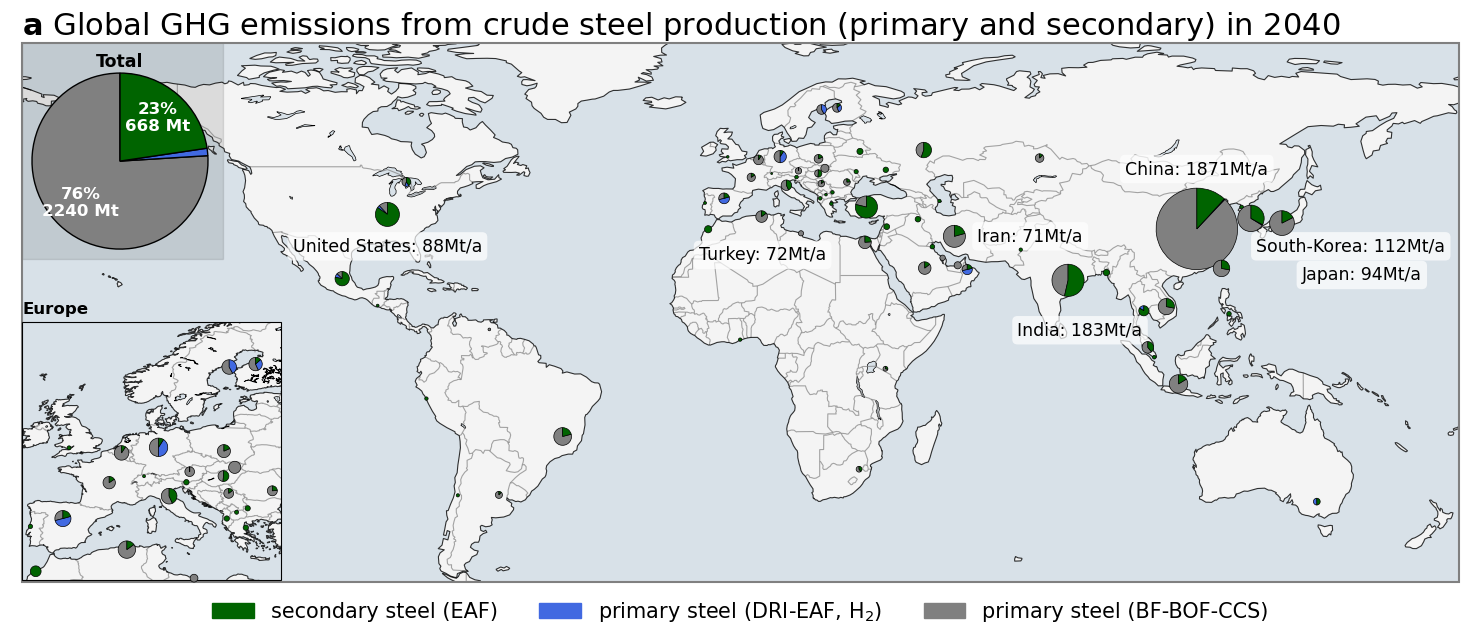

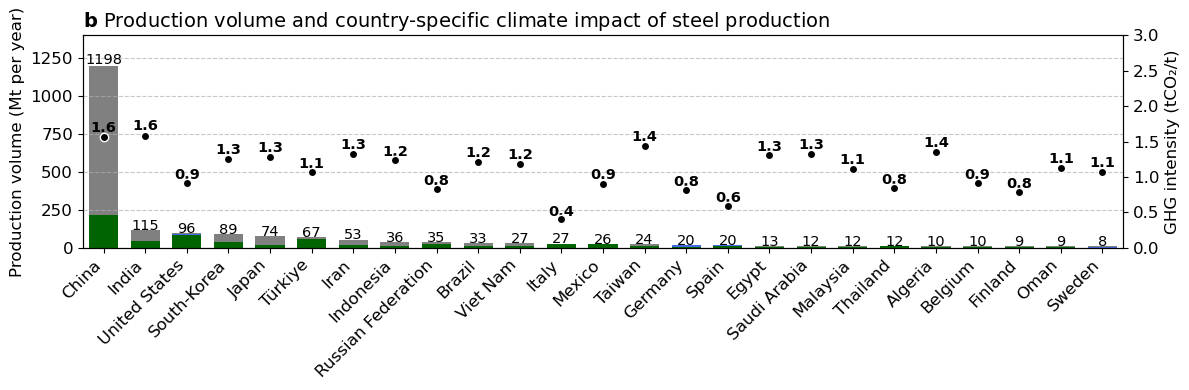


SCENARIO: future_ew

--- Overall production & emissions ---
Total GHG emissions (w/o transport):     3617.6 Mt CO₂-eq
Total steel production:                   2148.5 Mt
Average emissions intensity:                1.68 kg CO₂-eq/kg

--- Scope breakdown (volume-weighted totals) ---
Scope 1 total:      100.5 Mt CO₂-eq
Scope 2 total:     1548.8 Mt CO₂-eq
Scope 3 total:     1968.4 Mt CO₂-eq

--- CBAM coverage ---
CBAM-covered emissions:         2104.0 Mt CO₂-eq
Non-covered emissions:          1513.6 Mt CO₂-eq
Share covered by CBAM:          58.16%
CBAM-covered intensity:           0.98 kg CO₂-eq/kg


c:\Users\terlouw_t\.conda\envs\bw_reg_prem\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
c:\Users\terlouw_t\.conda\envs\bw_reg_prem\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


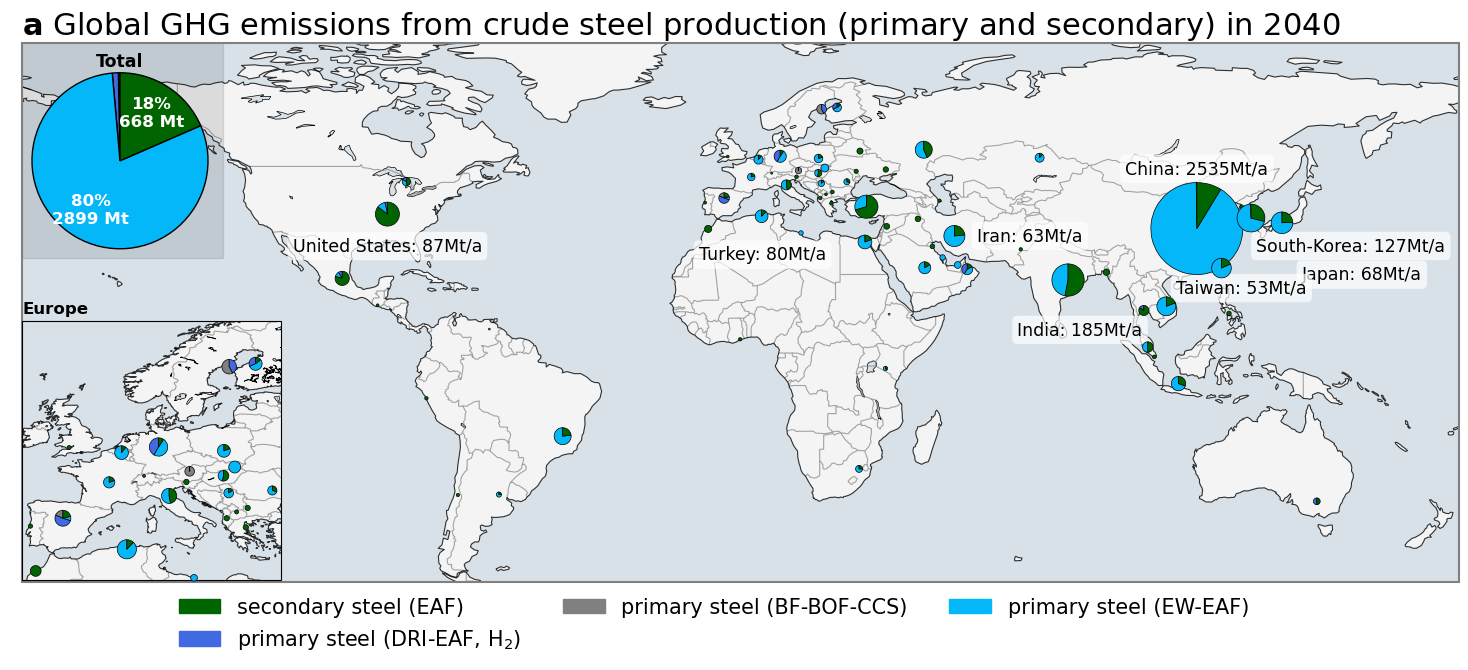

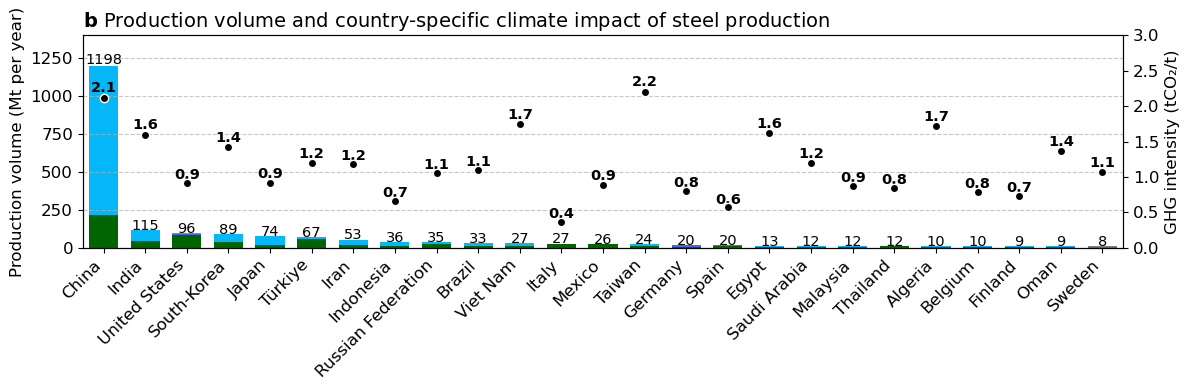


SCENARIO: future_ew_lc

--- Overall production & emissions ---
Total GHG emissions (w/o transport):     2228.6 Mt CO₂-eq
Total steel production:                   2148.5 Mt
Average emissions intensity:                1.04 kg CO₂-eq/kg

--- Scope breakdown (volume-weighted totals) ---
Scope 1 total:      100.5 Mt CO₂-eq
Scope 2 total:      156.7 Mt CO₂-eq
Scope 3 total:     1971.4 Mt CO₂-eq

--- CBAM coverage ---
CBAM-covered emissions:          711.2 Mt CO₂-eq
Non-covered emissions:          1517.3 Mt CO₂-eq
Share covered by CBAM:          31.91%
CBAM-covered intensity:           0.33 kg CO₂-eq/kg


c:\Users\terlouw_t\.conda\envs\bw_reg_prem\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
c:\Users\terlouw_t\.conda\envs\bw_reg_prem\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


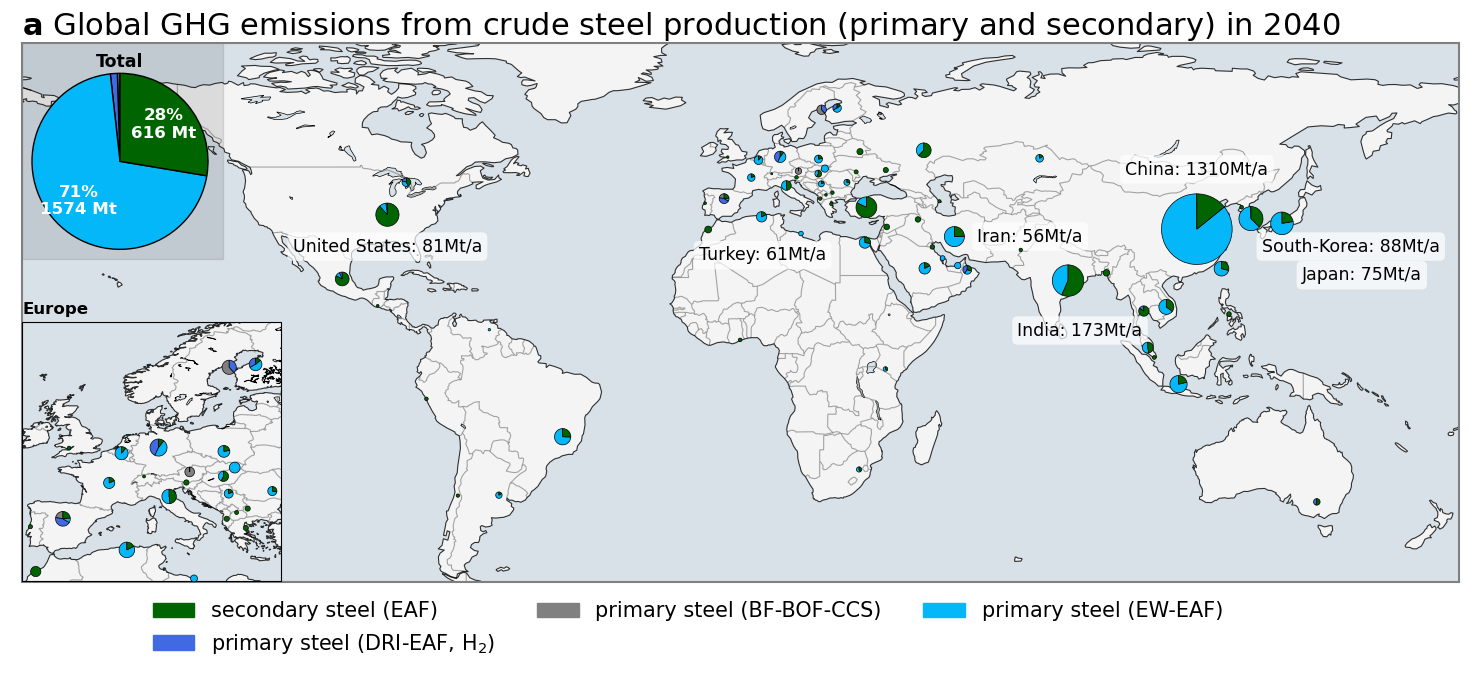

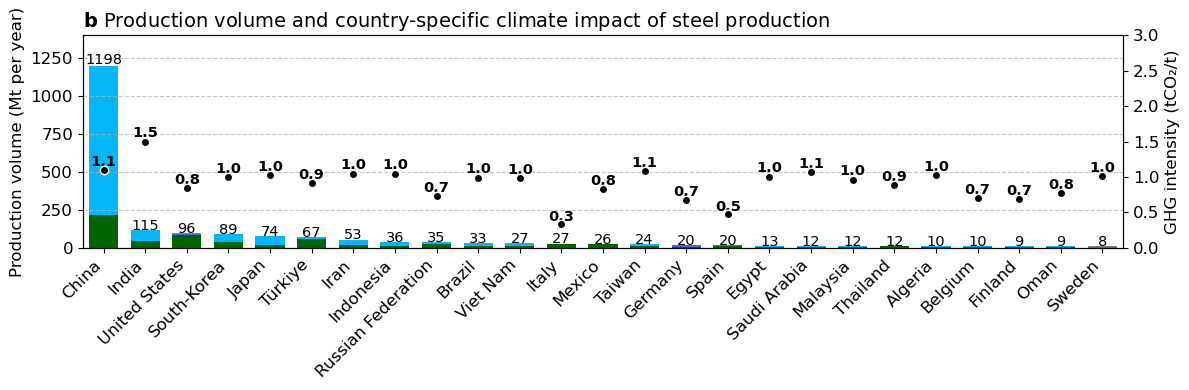

In [65]:
dict_pos = {'Brazil': (-7.5, 0),
                           'Viet Nam': (+17, +18),
                           'Ukraine': (+4, +22),
                        'China': (+15, 0),
                        'Germany': (+6, 0),
                        'India': (-12.5, -3),
                        'Iran, Islamic Republic of': (10, -19),
                        'Iran': (0, -19),
                           'Taiwan, Province of China'
                           : (-12, -19),
                        'Japan': (-13, -20),
                        #'Korea, Republic of': (+5, +45),
                           'South-Korea': (-7, -25),
                        'Russian Federation': (+10, -40),
                        'Türkiye': (-12, +26),
                        'United States': (-8, 0),
                        'Taiwan': (-5, -5),
                           'Egypt': (-14, 0)
                          }

pos_legend_false_subplot = [ (70, -7.5), (85, -9.5),(70, -7),(70, -7),(75, -8)]

titles = [r'$\mathbf{a}$ Global GHG emissions from crude steel production (primary and secondary) in 2040']
name_to_assess = "Plant_GHG_emissions_Mt_wo_transport"

for i, (case_key, df) in enumerate(results.items()):
    if df is None or df.empty:
        continue

    # -----------------------------
    # Summary statistics
    # -----------------------------
    total_emissions = df["Plant_GHG_emissions_Mt_wo_transport"].sum()
    total_production = df["production volume"].sum()
    emissions_intensity = (
        total_emissions / total_production
        if total_production > 0 else float("nan")
    )

    # =====================================================
    # Scope & CBAM calculations
    # =====================================================

    # Scope split
    df[['Scope 1', 'Scope 2', 'Scope 3']] = (
        df['lca_impact_contri_climate change']
        .apply(sum_scope_contributions)
        .apply(pd.Series)
    )

    # CBAM split
    df[['cbam_true', 'cbam_false']] = (
        df['lca_impact_contri_climate change']
        .apply(sum_cbam_contributions, alpha=alpha_fut)
        .apply(pd.Series)
    )

    # Totals (volume-weighted)
    df['cbam_true_total_cc'] = df['cbam_true'] * df['production volume']
    df['cbam_false_total_cc'] = df['cbam_false'] * df['production volume']

    df['share_cbam_covered'] = (
        df['cbam_true_total_cc'] /
        (df['cbam_true_total_cc'] + df['cbam_false_total_cc'])
    )

    # -----------------------------------------------------
    # Aggregate reporting
    # -----------------------------------------------------

    scope1_total = (df['Scope 1'] * df['production volume']).sum()
    scope2_total = (df['Scope 2'] * df['production volume']).sum()
    scope3_total = (df['Scope 3'] * df['production volume']).sum()

    cbam_true_total = df['cbam_true_total_cc'].sum()
    cbam_false_total = df['cbam_false_total_cc'].sum()
    cbam_share = cbam_true_total / (cbam_true_total + cbam_false_total)

    cbam_intensity = cbam_true_total / total_production

    # =====================================================
    # PRINT REPORT
    # =====================================================

    print("\n" + "=" * 70)
    print(f"SCENARIO: {case_key}")
    print("=" * 70)

    print("\n--- Overall production & emissions ---")
    print(f"Total GHG emissions (w/o transport): {total_emissions:10.1f} Mt CO₂-eq")
    print(f"Total steel production:               {total_production:10.1f} Mt")
    print(f"Average emissions intensity:          {emissions_intensity:10.2f} kg CO₂-eq/kg")

    print("\n--- Scope breakdown (volume-weighted totals) ---")
    print(f"Scope 1 total: {scope1_total:10.1f} Mt CO₂-eq")
    print(f"Scope 2 total: {scope2_total:10.1f} Mt CO₂-eq")
    print(f"Scope 3 total: {scope3_total:10.1f} Mt CO₂-eq")

    print("\n--- CBAM coverage ---")
    print(f"CBAM-covered emissions:     {cbam_true_total:10.1f} Mt CO₂-eq")
    print(f"Non-covered emissions:      {cbam_false_total:10.1f} Mt CO₂-eq")
    print(f"Share covered by CBAM:      {cbam_share:10.2%}")
    print(f"CBAM-covered intensity:     {cbam_intensity:10.2f} kg CO₂-eq/kg")

    print("=" * 70)

    # -----------------------------------------------------
    # Plots
    # -----------------------------------------------------

    plot_steel_map(
        df,
        [name_to_assess],
        subplot=False,
        titles=titles,
        division_bubble=20,
        amount_show_bubble=50,
        export_figure=f"annual_global_steel_emissions_2040_{case_key}",
        dict_pos=dict_pos,
        pos_legend_false_subplot=pos_legend_false_subplot[i],
    )

    plot_steel_production(
        df,
        production_col="production volume",
        export_figure=f"prod_fig_intensity_{case_key}",
        max_y=1400,
    )

    # Store back
    results[case_key] = df


In [66]:
results[case_key].iloc[1]['lca_impact_contri_climate change']

[('Benzene', 0.0, 1, True, 3.410321381705713e-07),
 ('Hexachlorobenzene', 0.0, 1, True, 1.45416592316503e-09),
 ('Cadmium II', 0.0, 1, True, 1.141929257057926e-08),
 ('Carbon dioxide, fossil', 0.04143920984106193, 1, True, 0.04143920984106193),
 ('Carbon monoxide, fossil', 0.0, 1, True, 0.0004452455641371955),
 ('Chromium III', 0.0, 1, True, 1.720592323861804e-07),
 ('Copper ion', 0.0, 1, True, 7.030557637037507e-08),
 ('Dioxins, measured as 2,3,7,8-tetrachlorodibenzo-p-dioxin',
  0.0,
  1,
  True,
  4.598476413002894e-13),
 ('Hydrocarbons, aromatic', 0.0, 1, True, 7.228433445289023e-05),
 ('Hydrochloric acid', 0.0, 1, True, 4.984629650446371e-06),
 ('Hydrogen fluoride', 0.0, 1, True, 2.299238206501447e-08),
 ('Lead II', 0.0, 1, True, 4.33971694658369e-07),
 ('Mercury II', 0.0, 1, True, 1.877320134346827e-08),
 ('Nickel II', 0.0, 1, True, 7.270829615825128e-08),
 ('Nitrogen oxides', 0.0, 1, True, 7.258701451225186e-05),
 ('PAH, polycyclic aromatic hydrocarbons',
  0.0,
  1,
  True,
  8